# DIISCO CAR T Robustness

In [1]:
cd ..

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline
import seaborn as sns
#import tensorflow as tf
#from Scalable_GPRN.model.SGPRN import SGPRN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
# reload edited modules always
%load_ext autoreload
%autoreload 2
from diisco import DIISCO
import diisco.names as names
import omnipath
from tqdm import tqdm_notebook
import scanpy as sc
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors2
import matplotlib as mpl

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
torch.set_default_dtype(torch.float64)

## Robustness across experiments: CAR A - D

Summarize results across biological replicates

In [4]:
# experiments = ['CARA', 'CARB', 'CARC', 'CARD']
experiments = ['CARA', 'CARC', 'CARD']

W_avg_experiments = []
for experiment in experiments:
    W_avg = np.load(f'../../data/CAR-T/W_{experiment}.npy').mean(axis=0)
    W_avg_experiments.append(W_avg)

W_avg_experiments = np.array(W_avg_experiments)
W_avg_experiments.shape

(3, 4, 4)

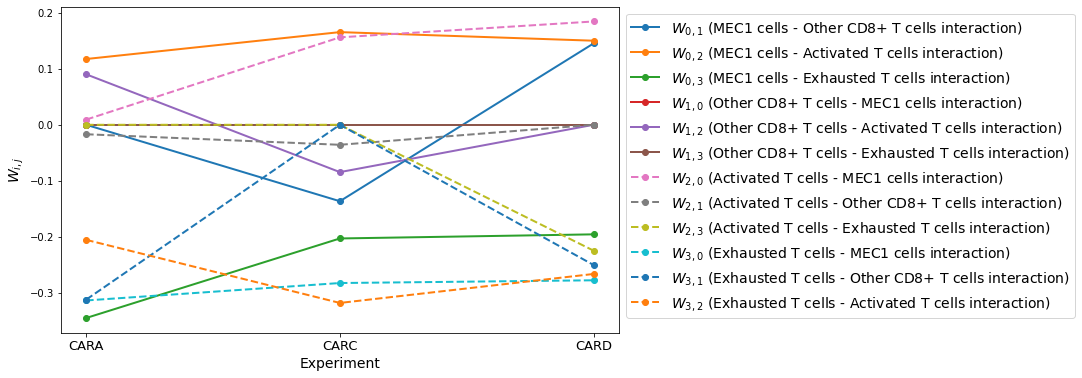

In [5]:
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']

plt.figure(figsize=(10, 6))
linestyles = ['-', '--']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        if i != j:
            plt.plot(range(len(experiments)), 
                     W_avg_experiments[:, i, j],
                     linestyle=linestyles[i//2],
                     linewidth=2,
                     marker='o',
                     label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.xticks(range(len(experiments)), experiments, fontsize=13)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Experiment', fontsize=14)
plt.savefig('../../figures/CAR-T/revisions/robustness_experiments/W_avg_over_CAR_experiments.eps', 
            bbox_inches='tight')

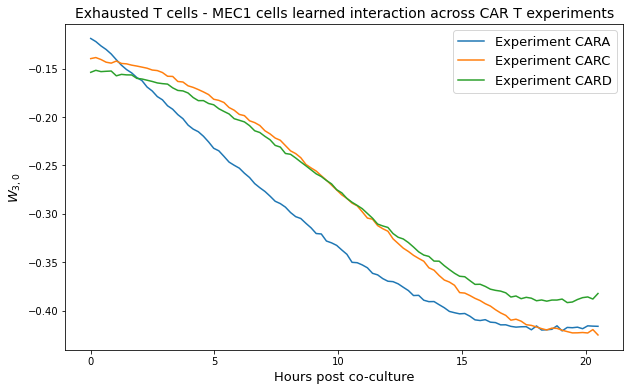

In [6]:
experiments = ['CARA', 'CARC', 'CARD']
predict_timepoints = np.load(f'../../data/CAR-T/X_CARC.npy')
plt.figure(figsize=(10, 6))
for experiment in experiments:
    W_exhausted_mec1 = np.load(f'../../data/CAR-T/W_{experiment}.npy')[:, 3, 0]
    plt.plot(predict_timepoints, W_exhausted_mec1, label=f'Experiment {experiment}')
plt.ylabel('$W_{3, 0}$', fontsize=13)
plt.xlabel('Hours post co-culture', fontsize=13)
plt.title('Exhausted T cells - MEC1 cells learned interaction across CAR T experiments', 
          fontsize=14)
plt.legend(fontsize=13)
plt.savefig('../../figures/CAR-T/revisions/robustness_experiments/W_exhausted_mec1_over_CAR_experiments.eps', 
            bbox_inches='tight')

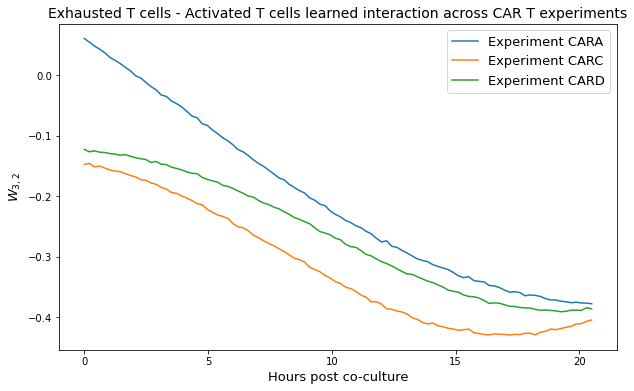

In [7]:
experiments = ['CARA', 'CARC', 'CARD']
predict_timepoints = np.load(f'../../data/CAR-T/X_CARC.npy')
plt.figure(figsize=(10, 6))
for experiment in experiments:
    W_exhausted_activated = np.load(f'../../data/CAR-T/W_{experiment}.npy')[:, 3, 2]
    plt.plot(predict_timepoints, W_exhausted_activated, label=f'Experiment {experiment}')
plt.ylabel('$W_{3, 2}$', fontsize=13)
plt.xlabel('Hours post co-culture', fontsize=13)
plt.title('Exhausted T cells - Activated T cells learned interaction across CAR T experiments', 
          fontsize=14)
plt.legend(fontsize=13)
plt.savefig('../../figures/CAR-T/revisions/robustness_experiments/W_exhausted_activated_over_CAR_experiments.eps', 
            bbox_inches='tight')

## Robustness over number of cells

In [4]:
df = pickle.load(open('../data/CAR-T ratios and umap/CAR_T_umap_revised.pkl', "rb"))
df = df[df.index.str.startswith('CARC')]
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
df['metacluster'] = df['metacluster'].replace([0, 1, 2, 3], cell_types)

# Drop cells not in MCs
df = df.dropna(subset=['metacluster'])

# Drop clusters with < 100 cells
cluster_counts = df['cluster_number'].value_counts()
drop_clusters = cluster_counts.index[cluster_counts < 100]
df = df[~df['cluster_number'].isin(drop_clusters)]

df

,x,y,c,cluster_number,metacluster,DATA,time
CARC_T8_AAACCTGAGAAGGCCT,5.567172,0.087582,1.495141,12,Activated T cells,CARC,T8
CARC_T9_AAACCTGAGACAAGCC,1.502741,-0.987649,1.320962,3,Activated T cells,CARC,T9
CARC_T6_AAACCTGAGACAATAC,4.663743,-0.975110,0.492641,3,Activated T cells,CARC,T6
CARC_T9_AAACCTGAGCCATCGC,15.180671,4.691824,-2.302585,10,MEC1 cells,CARC,T9
CARC_T2_AAACCTGAGGTAGCTG,13.630413,2.641607,-0.990700,17,MEC1 cells,CARC,T2
...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,12.010520,4.462165,-2.302585,17,MEC1 cells,CARC,T9
CARC_T9_TTTGTCATCGACGGAA,11.207350,-3.329571,1.203709,15,Exhausted T cells,CARC,T9
CARC_T9_TTTGTCATCGGCTTGG,11.399427,-4.040952,1.123553,15,Exhausted T cells,CARC,T9
CARC_T7_TTTGTCATCGTGGGAA,6.844381,-2.513008,1.062368,9,Exhausted T cells,CARC,T7


In [5]:
df['metacluster'].value_counts()

Exhausted T cells     3565
MEC1 cells            3126
Activated T cells     2052
Other CD8+ T cells     339
Name: metacluster, dtype: int64

In [6]:
drop_cells_fractions = np.linspace(0.1, 0.9, 5)
drop_cells_fractions

array([0.1, 0.3, 0.5, 0.7, 0.9])

0.1
[iteration 0001] loss: 2991.7450
[iteration 0101] loss: 1536.9781
[iteration 0201] loss: 1621.3057
[iteration 0301] loss: 1370.9316
[iteration 0401] loss: 1373.6856
[iteration 0501] loss: 1242.2429
[iteration 0601] loss: 1251.8301
[iteration 0701] loss: 1223.2436
[iteration 0801] loss: 1241.1440
[iteration 0901] loss: 1193.9983
[iteration 1001] loss: 1188.6593
[iteration 1101] loss: 1139.5846
[iteration 1201] loss: 1123.1491
[iteration 1301] loss: 1082.3214
[iteration 1401] loss: 1102.6386
[iteration 1501] loss: 1075.4238
[iteration 1601] loss: 1134.2606
[iteration 1701] loss: 1039.8771
[iteration 1801] loss: 1038.8723
[iteration 1901] loss: 1060.0088
[iteration 2001] loss: 1006.6578
[iteration 2101] loss: 969.1323
[iteration 2201] loss: 967.5896
[iteration 2301] loss: 1014.3115
[iteration 2401] loss: 1073.8910
[iteration 2501] loss: 936.7749
[iteration 2601] loss: 976.6484
[iteration 2701] loss: 1357.1591
[iteration 2801] loss: 980.6255
[iteration 2901] loss: 934.9594
[iteration 3

100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 404.55it/s]


0.30000000000000004
[iteration 0001] loss: 2959.9182
[iteration 0101] loss: 1583.9966
[iteration 0201] loss: 1446.1177
[iteration 0301] loss: 1384.2060
[iteration 0401] loss: 1355.2191
[iteration 0501] loss: 1275.3549
[iteration 0601] loss: 1250.1033
[iteration 0701] loss: 1205.8486
[iteration 0801] loss: 1191.0269
[iteration 0901] loss: 1153.8316
[iteration 1001] loss: 1163.1340
[iteration 1101] loss: 1128.5440
[iteration 1201] loss: 1113.2316
[iteration 1301] loss: 1137.4546
[iteration 1401] loss: 1064.1626
[iteration 1501] loss: 1083.2435
[iteration 1601] loss: 1062.2333
[iteration 1701] loss: 1016.0287
[iteration 1801] loss: 1026.7669
[iteration 1901] loss: 1060.8662
[iteration 2001] loss: 985.3972
[iteration 2101] loss: 995.1878
[iteration 2201] loss: 1012.4966
[iteration 2301] loss: 988.5084
[iteration 2401] loss: 964.2998
[iteration 2501] loss: 1038.2976
[iteration 2601] loss: 953.6528
[iteration 2701] loss: 951.7612
[iteration 2801] loss: 938.3236
[iteration 2901] loss: 1003.54

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 389.68it/s]


0.5
[iteration 0001] loss: 2966.0125
[iteration 0101] loss: 1556.2486
[iteration 0201] loss: 1435.6633
[iteration 0301] loss: 1378.2712
[iteration 0401] loss: 1343.8113
[iteration 0501] loss: 1344.3240
[iteration 0601] loss: 1280.6993
[iteration 0701] loss: 1274.6639
[iteration 0801] loss: 1276.9264
[iteration 0901] loss: 1184.8266
[iteration 1001] loss: 1185.5606
[iteration 1101] loss: 1148.9500
[iteration 1201] loss: 1169.9330
[iteration 1301] loss: 1153.7436
[iteration 1401] loss: 1129.9717
[iteration 1501] loss: 1086.0378
[iteration 1601] loss: 1104.6213
[iteration 1701] loss: 1058.9092
[iteration 1801] loss: 1039.5438
[iteration 1901] loss: 1022.7652
[iteration 2001] loss: 1070.8620
[iteration 2101] loss: 1022.0327
[iteration 2201] loss: 998.1748
[iteration 2301] loss: 980.1574
[iteration 2401] loss: 973.9098
[iteration 2501] loss: 1055.9162
[iteration 2601] loss: 992.8186
[iteration 2701] loss: 1030.1933
[iteration 2801] loss: 976.2737
[iteration 2901] loss: 935.8574
[iteration 3

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 389.60it/s]


0.7000000000000001
[iteration 0001] loss: 2963.0369
[iteration 0101] loss: 1597.0417
[iteration 0201] loss: 1429.9306
[iteration 0301] loss: 1349.1829
[iteration 0401] loss: 1323.0955
[iteration 0501] loss: 1326.2779
[iteration 0601] loss: 1267.7499
[iteration 0701] loss: 1230.3689
[iteration 0801] loss: 1237.8401
[iteration 0901] loss: 1175.2560
[iteration 1001] loss: 1143.3211
[iteration 1101] loss: 1119.5079
[iteration 1201] loss: 1165.3636
[iteration 1301] loss: 1122.5855
[iteration 1401] loss: 1082.9162
[iteration 1501] loss: 1094.2298
[iteration 1601] loss: 1034.2303
[iteration 1701] loss: 1058.7641
[iteration 1801] loss: 1058.9483
[iteration 1901] loss: 1071.5736
[iteration 2001] loss: 1016.1771
[iteration 2101] loss: 977.2814
[iteration 2201] loss: 984.8770
[iteration 2301] loss: 1000.4161
[iteration 2401] loss: 1041.2728
[iteration 2501] loss: 956.9422
[iteration 2601] loss: 961.8902
[iteration 2701] loss: 945.1682
[iteration 2801] loss: 954.5121
[iteration 2901] loss: 899.101

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 387.68it/s]


0.9
[iteration 0001] loss: 2969.7771
[iteration 0101] loss: 1582.6992
[iteration 0201] loss: 1463.1796
[iteration 0301] loss: 1384.6817
[iteration 0401] loss: 1440.7610
[iteration 0501] loss: 1299.8950
[iteration 0601] loss: 1254.5792
[iteration 0701] loss: 1235.3723
[iteration 0801] loss: 1243.6830
[iteration 0901] loss: 1172.4681
[iteration 1001] loss: 1165.5041
[iteration 1101] loss: 1133.0121
[iteration 1201] loss: 1132.9728
[iteration 1301] loss: 1108.4801
[iteration 1401] loss: 1330.4170
[iteration 1501] loss: 1114.3077
[iteration 1601] loss: 1122.1074
[iteration 1701] loss: 1056.0414
[iteration 1801] loss: 1040.4356
[iteration 1901] loss: 1147.9091
[iteration 2001] loss: 1009.8746
[iteration 2101] loss: 1040.8978
[iteration 2201] loss: 1017.1252
[iteration 2301] loss: 996.5374
[iteration 2401] loss: 1021.7365
[iteration 2501] loss: 1009.1645
[iteration 2601] loss: 973.3874
[iteration 2701] loss: 968.4802
[iteration 2801] loss: 948.7175
[iteration 2901] loss: 950.7108
[iteration 

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 386.50it/s]


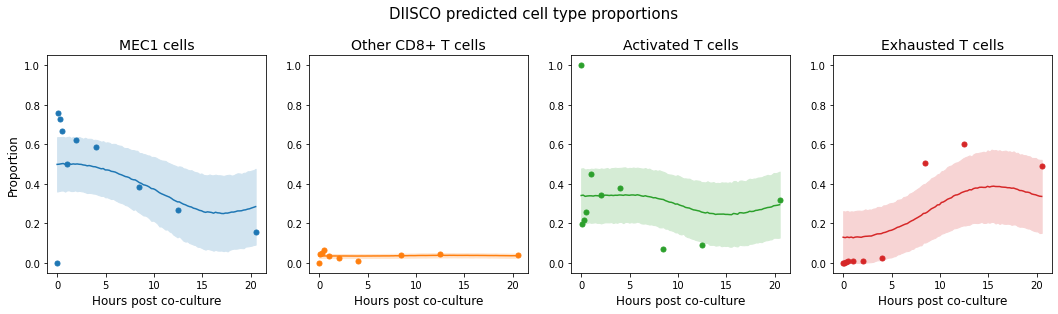

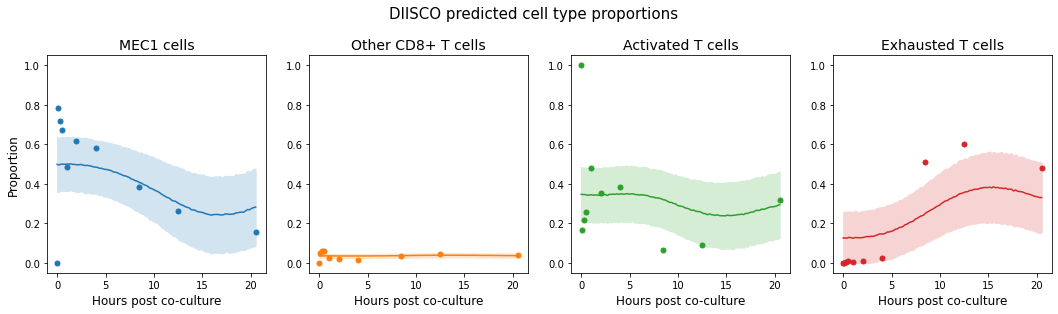

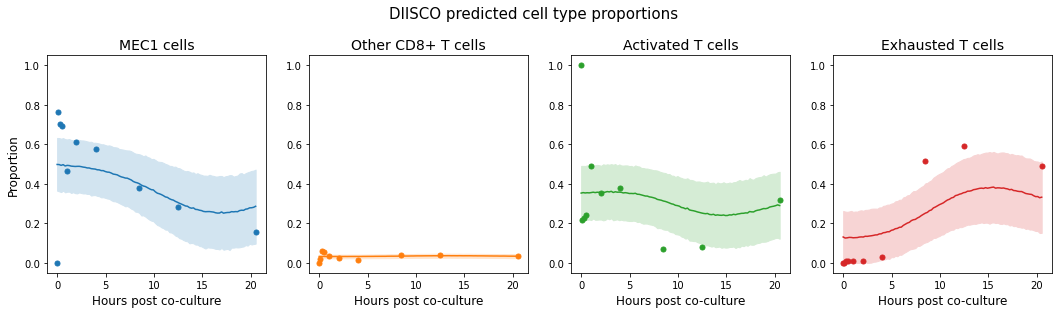

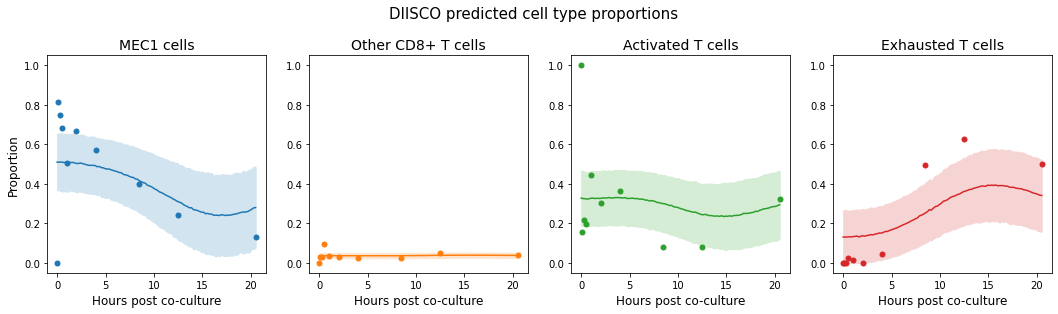

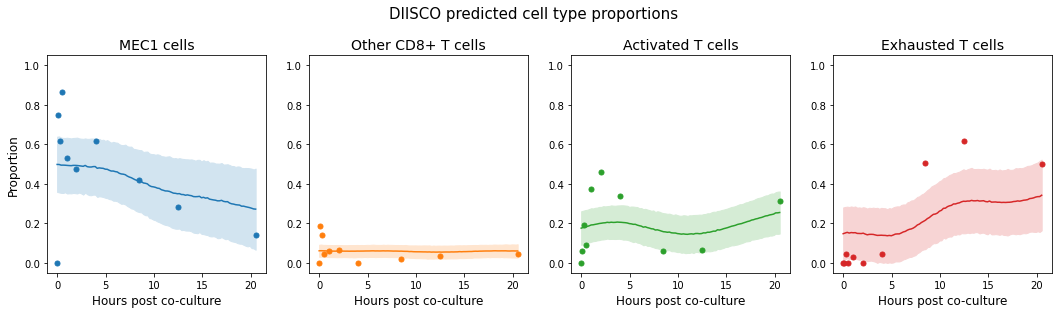

In [7]:
np.random.seed(0)
predictions = {}
for drop_fraction in drop_cells_fractions:
    print(drop_fraction)
    num_cells_to_keep = int((1 - drop_fraction) * df.shape[0])
    cells_to_keep = np.random.choice(df.index, size=num_cells_to_keep, replace=False)
    df_subset = df.loc[cells_to_keep]
    
    num_cells_per_cluster_over_time = df_subset.pivot_table(index='time', columns='metacluster', 
                                                            values='DATA', aggfunc='count')
    num_cells_per_cluster_over_time = num_cells_per_cluster_over_time.fillna(0)
    cluster_proportions_over_time = num_cells_per_cluster_over_time.\
                                        divide(num_cells_per_cluster_over_time.sum(axis=1),
                                               axis=0)
    for time_index in range(10):
        time_str = 'T' + str(time_index)
        if time_str not in cluster_proportions_over_time.index:
            cluster_proportions_over_time.loc[time_str] = [0] * df['metacluster'].nunique()
            cluster_proportions_over_time = cluster_proportions_over_time.sort_index()
    cluster_proportions_over_time.index = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
    cluster_proportions_over_time = cluster_proportions_over_time[cell_types]
    cluster_proportions_over_time.index.name = 'Hours post co-culture'
    
    X = cluster_proportions_over_time.index.values.reshape(-1, 1)
    Y = cluster_proportions_over_time.values
    W_prior_variance = np.load(f'../../data/CAR-T/interaction_prior_CARC.npy')
    
    timepoints = torch.tensor(X)
    proportions = torch.tensor(Y)
    # z score the proportions
    proportions_mean = proportions.mean(dim=0)
    proportions_std = proportions.std(dim=0)
    proportions = (proportions - proportions_mean) / (proportions_std)
    prior_matrix = torch.tensor(W_prior_variance)
    
    def unscale(proportions, cluster_index): 
        return np.clip(proportions * 
                       proportions_std.detach().numpy()[cluster_index] + 
                       proportions_mean.detach().numpy()[cluster_index], 
                       0, None)
    
    lengthscale_f = np.mean(np.abs(X - X.T))
    j = W_prior_variance.sum(axis=1).max()
    lengthscale_W = max([X[i, 0] - X[i-j+1, 0] 
                         for i in range(j-1, X.shape[0])])
    hyper_init_vals = {
        names.LENGTHSCALE_F: lengthscale_f,
        names.LENGTHSCALE_W: lengthscale_W,
        names.SIGMA_F: 0.5,
        names.VARIANCE_F: 1,
        names.SIGMA_W: 0.1,
        names.VARIANCE_W: 1,
        names.SIGMA_Y: 0.5,
    }
    
    model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)
    model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
    model.fit(timepoints, 
              proportions, 
              n_iter=10000, 
              lr=0.00005,
              hypers_to_optim=[], 
              guide="MultivariateNormalFactorized")
    
    predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
    samples = model.sample(predict_timepoints, 
                           n_samples=10000, 
                           n_samples_per_latent=10,
                           include_emission_variance=True)
    
    predictions[drop_fraction] = {
        'W_samples_predict': samples['W'],
        'y_samples_predict': samples['Y']
    }

    cell_type_color = [('MEC1 cells', 'tab:blue'), 
                       ('Other CD8+ T cells', 'tab:orange'), 
                       ('Activated T cells', 'tab:green'),
                       ('Exhausted T cells', 'tab:red')]
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        cell_type_samples = samples['Y'][:, :, i]
        mean = unscale(cell_type_samples.mean(axis=0), i)
        x = predict_timepoints.squeeze().numpy()
        percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
        percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
        ax = axes[i]
        color_with_alpha = list(colors2.to_rgb(cell_type_color[i][1])) + [0.2]
        color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
        line = ax.plot(x, mean, c=cell_type_color[i][1])
        ax.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
        ax.scatter(timepoints, unscale(proportions[:, i], i), c=cell_type_color[i][1], s=25)
        ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
        ax.set_xlabel('Hours post co-culture', fontsize=12)
        if i==0: ax.set_ylabel('Proportion', fontsize=12)
        ax.set_ylim([-0.05, 1.05])
    plt.suptitle('DIISCO predicted cell type proportions', fontsize=15, y=1.05)
    plt.savefig(f'../../figures/CAR-T/revisions/robustness_cells/predicted_proportions_for_downsampled_cells_{str(drop_fraction)[:4]}.eps', 
                bbox_inches='tight')

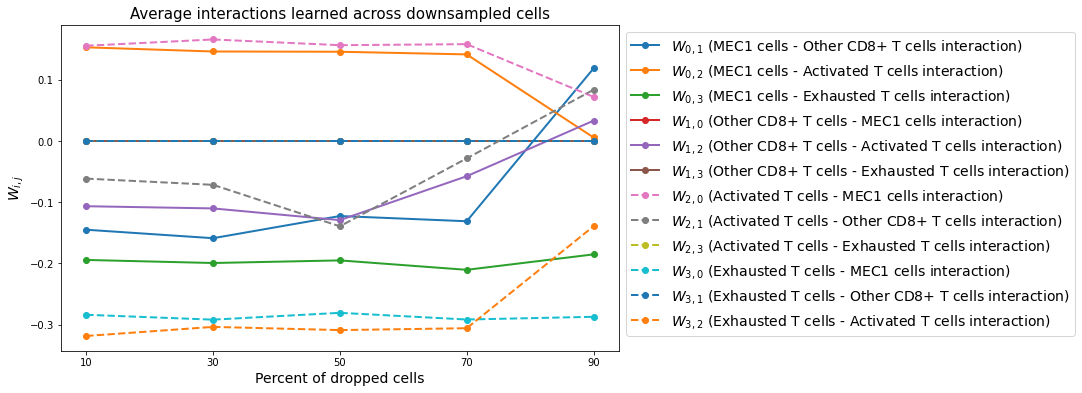

In [9]:
W_avg_over_drop_fractions = np.stack([predictions[drop_fraction]['W_samples_predict'].mean(axis=[0, 1]) 
                                      for drop_fraction in drop_cells_fractions])

plt.figure(figsize=(10, 6))
linestyles = ['-', '--']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        if i != j:
            plt.plot((drop_cells_fractions * 100).astype(int), 
                     W_avg_over_drop_fractions[:, i, j],
                     linestyle=linestyles[i//2],
                     linewidth=2,
                     marker='o',
                     label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Percent of dropped cells', fontsize=14)
plt.xticks((drop_cells_fractions * 100).astype(int), (drop_cells_fractions * 100).astype(int))
plt.title('Average interactions learned across downsampled cells', fontsize=15)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cells/W_avg_over_downsampled_cells.eps', 
            bbox_inches='tight')

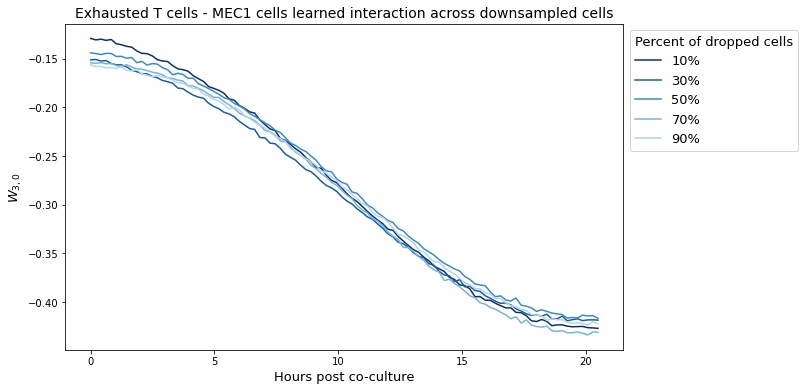

In [10]:
plt.figure(figsize=(10, 6))
cmap = mpl.colormaps['Blues_r']
colors = cmap(np.linspace(0, 0.7, len(drop_cells_fractions)))
for i, drop_fraction in enumerate(drop_cells_fractions):
    W_exhausted_mec1 = predictions[drop_fraction]['W_samples_predict'].mean(axis=0)[:, 3, 0]
    plt.plot(predict_timepoints, W_exhausted_mec1, 
             label=f'{int(drop_fraction * 100)}%',
             color=colors[i])
plt.ylabel('$W_{3, 0}$', fontsize=13)
plt.xlabel('Hours post co-culture', fontsize=13)
plt.title('Exhausted T cells - MEC1 cells learned interaction across downsampled cells', 
          fontsize=14)
leg = plt.legend(title='Percent of dropped cells', bbox_to_anchor=(1, 1), loc='upper left',
           fontsize=13, title_fontsize=13)
leg._legend_box.align = "left"
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cells/W_exhausted_mec1_over_downsampled_cells.eps', 
            bbox_inches='tight')

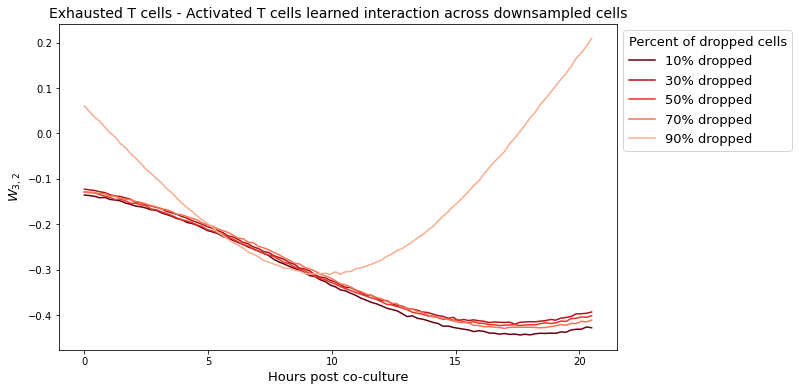

In [11]:
plt.figure(figsize=(10, 6))
cmap = mpl.colormaps['Reds_r']
colors = cmap(np.linspace(0, 0.7, len(drop_cells_fractions)))
for i, drop_fraction in enumerate(drop_cells_fractions):
    W_exhausted_activated = predictions[drop_fraction]['W_samples_predict'].mean(axis=0)[:, 3, 2]
    plt.plot(predict_timepoints, W_exhausted_activated, 
             label=f'{int(drop_fraction * 100)}% dropped',
             color=colors[i])
plt.ylabel('$W_{3, 2}$', fontsize=13)
plt.xlabel('Hours post co-culture', fontsize=13)
plt.title('Exhausted T cells - Activated T cells learned interaction across downsampled cells', 
          fontsize=14)
leg = plt.legend(title='Percent of dropped cells', bbox_to_anchor=(1, 1), loc='upper left',
           fontsize=13, title_fontsize=13)
leg._legend_box.align = "left"
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cells/W_exhausted_activated_over_downsampled_cells.eps', 
            bbox_inches='tight')

## Robustness over number of timepoints

In [15]:
df = pd.read_csv(f'../../data/CAR-T ratios and umap/CARC_ratios_processed.pkl', 
                 index_col='Hours post co-culture')
df.columns = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells',
              'total_cells_per_sample']
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
df

,MEC1 cells,Other CD8+ T cells,Activated T cells,Exhausted T cells,total_cells_per_sample
Hours post co-culture,,,,,
0.000000,0.000000,0.000000,1.000000,0.000000,3.0
0.083333,0.773585,0.047170,0.179245,0.000000,106.0
0.250000,0.726852,0.055556,0.212963,0.004630,216.0
0.500000,0.691489,0.063830,0.234043,0.010638,188.0
1.000000,0.493363,0.030973,0.466814,0.008850,452.0
2.000000,0.613084,0.026168,0.349533,0.011215,535.0
4.000000,0.583333,0.010563,0.373239,0.032864,852.0
8.500000,0.388668,0.036282,0.072565,0.502485,2012.0
12.500000,0.266527,0.042497,0.093914,0.597062,1906.0


In [16]:
X = df.index.values.reshape(-1, 1)
X[:3]

array([[0.        ],
       [0.08333333],
       [0.25      ]])

In [17]:
Y = df[cell_types].values
Y

array([[0.        , 0.        , 1.        , 0.        ],
       [0.77358491, 0.04716981, 0.17924528, 0.        ],
       [0.72685185, 0.05555556, 0.21296296, 0.00462963],
       [0.69148936, 0.06382979, 0.23404255, 0.0106383 ],
       [0.49336283, 0.03097345, 0.46681416, 0.00884956],
       [0.61308411, 0.02616822, 0.34953271, 0.01121495],
       [0.58333333, 0.01056338, 0.37323944, 0.03286385],
       [0.38866799, 0.03628231, 0.07256461, 0.50248509],
       [0.26652676, 0.04249738, 0.09391396, 0.59706191],
       [0.15824916, 0.04276094, 0.31144781, 0.48754209]])

Text(0.5, 1.02, 'Interaction prior variances based on receptor-ligand expression')

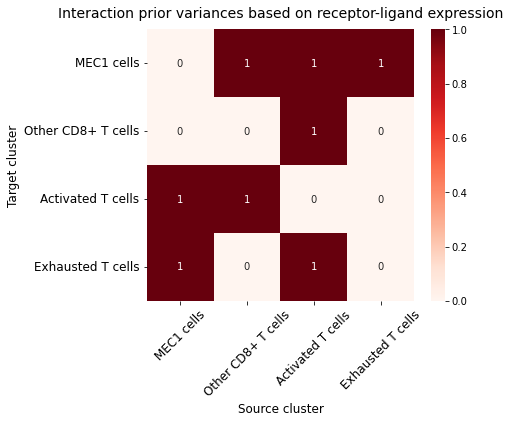

In [18]:
W_prior_variance = np.load(f'../../data/CAR-T/interaction_prior_CARC.npy')

plt.figure(figsize=(6, 5))
ax = sns.heatmap(W_prior_variance, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12, rotation=0)
ax.set_xticklabels(cell_types, fontsize=12, rotation=45)
plt.xlabel('Source cluster', fontsize=12)
plt.ylabel('Target cluster', fontsize=12)
plt.title('Interaction prior variances based on receptor-ligand expression', 
          fontsize=14, y=1.02)

In [19]:
drop_timepoints_fractions = np.linspace(0, 0.5, 6)
drop_timepoints_fractions

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

0.0
[iteration 0001] loss: 2960.5214
[iteration 0101] loss: 1631.5003
[iteration 0201] loss: 1655.2686
[iteration 0301] loss: 1587.0985
[iteration 0401] loss: 1571.3511
[iteration 0501] loss: 1337.1017
[iteration 0601] loss: 1393.8710
[iteration 0701] loss: 1310.0375
[iteration 0801] loss: 1428.0132
[iteration 0901] loss: 1259.7446
[iteration 1001] loss: 1246.8968
[iteration 1101] loss: 1447.9374
[iteration 1201] loss: 1253.7230
[iteration 1301] loss: 1210.8445
[iteration 1401] loss: 1166.5704
[iteration 1501] loss: 1160.5991
[iteration 1601] loss: 1081.1632
[iteration 1701] loss: 1191.6308
[iteration 1801] loss: 1173.8071
[iteration 1901] loss: 1151.1677
[iteration 2001] loss: 1206.3608
[iteration 2101] loss: 1221.0099
[iteration 2201] loss: 1081.9937
[iteration 2301] loss: 1058.6130
[iteration 2401] loss: 1018.6855
[iteration 2501] loss: 1017.2783
[iteration 2601] loss: 1017.5813
[iteration 2701] loss: 1000.3709
[iteration 2801] loss: 969.2615
[iteration 2901] loss: 990.8014
[iterati

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 396.98it/s]


0.1
[iteration 0001] loss: 2978.1556
[iteration 0101] loss: 1620.0995
[iteration 0201] loss: 1457.8723
[iteration 0301] loss: 1404.3739
[iteration 0401] loss: 1311.1922
[iteration 0501] loss: 1287.5625
[iteration 0601] loss: 1275.6545
[iteration 0701] loss: 1300.7362
[iteration 0801] loss: 1234.1358
[iteration 0901] loss: 1202.9905
[iteration 1001] loss: 1155.1798
[iteration 1101] loss: 1153.3682
[iteration 1201] loss: 1133.9112
[iteration 1301] loss: 1110.1119
[iteration 1401] loss: 1101.0326
[iteration 1501] loss: 1073.1934
[iteration 1601] loss: 1082.8137
[iteration 1701] loss: 1066.3533
[iteration 1801] loss: 1113.6166
[iteration 1901] loss: 1047.2823
[iteration 2001] loss: 1046.9872
[iteration 2101] loss: 1013.8274
[iteration 2201] loss: 1044.6930
[iteration 2301] loss: 999.6471
[iteration 2401] loss: 985.1327
[iteration 2501] loss: 994.4959
[iteration 2601] loss: 1023.2115
[iteration 2701] loss: 952.2277
[iteration 2801] loss: 960.8053
[iteration 2901] loss: 953.1092
[iteration 3

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 385.13it/s]


0.2
[iteration 0001] loss: 2995.0578
[iteration 0101] loss: 1606.2780
[iteration 0201] loss: 1734.3964
[iteration 0301] loss: 1415.0059
[iteration 0401] loss: 1363.6635
[iteration 0501] loss: 1343.1657
[iteration 0601] loss: 1525.9003
[iteration 0701] loss: 1310.6219
[iteration 0801] loss: 1250.9835
[iteration 0901] loss: 1274.8221
[iteration 1001] loss: 1190.8385
[iteration 1101] loss: 1214.0417
[iteration 1201] loss: 1180.3536
[iteration 1301] loss: 1237.7980
[iteration 1401] loss: 1232.2409
[iteration 1501] loss: 1174.4869
[iteration 1601] loss: 1124.5556
[iteration 1701] loss: 1117.4803
[iteration 1801] loss: 1092.4791
[iteration 1901] loss: 1129.9804
[iteration 2001] loss: 1086.3002
[iteration 2101] loss: 1080.5813
[iteration 2201] loss: 1090.5859
[iteration 2301] loss: 1206.2903
[iteration 2401] loss: 1096.2841
[iteration 2501] loss: 1002.5643
[iteration 2601] loss: 984.9016
[iteration 2701] loss: 999.9462
[iteration 2801] loss: 1001.5767
[iteration 2901] loss: 960.8039
[iteratio

100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 375.99it/s]


0.30000000000000004
[iteration 0001] loss: 3103.7822
[iteration 0101] loss: 1749.5336
[iteration 0201] loss: 1590.3368
[iteration 0301] loss: 1534.6030
[iteration 0401] loss: 1470.8294
[iteration 0501] loss: 1438.9691
[iteration 0601] loss: 1362.5912
[iteration 0701] loss: 1376.0979
[iteration 0801] loss: 1318.3877
[iteration 0901] loss: 1312.6565
[iteration 1001] loss: 1274.2489
[iteration 1101] loss: 1269.6941
[iteration 1201] loss: 1252.0287
[iteration 1301] loss: 1206.9858
[iteration 1401] loss: 1213.9156
[iteration 1501] loss: 1179.3288
[iteration 1601] loss: 1201.3368
[iteration 1701] loss: 1161.3204
[iteration 1801] loss: 1160.7243
[iteration 1901] loss: 1140.0626
[iteration 2001] loss: 1128.0489
[iteration 2101] loss: 1120.7920
[iteration 2201] loss: 1099.9277
[iteration 2301] loss: 1073.0250
[iteration 2401] loss: 1104.0194
[iteration 2501] loss: 1077.4361
[iteration 2601] loss: 1040.0096
[iteration 2701] loss: 1026.9743
[iteration 2801] loss: 1038.4678
[iteration 2901] loss: 

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 387.69it/s]


0.4
[iteration 0001] loss: 3117.9965
[iteration 0101] loss: 1794.6717
[iteration 0201] loss: 1693.1799
[iteration 0301] loss: 1617.0357
[iteration 0401] loss: 1520.6847
[iteration 0501] loss: 1528.1773
[iteration 0601] loss: 1502.0958
[iteration 0701] loss: 1420.3933
[iteration 0801] loss: 1447.9296
[iteration 0901] loss: 1410.2449
[iteration 1001] loss: 1401.4219
[iteration 1101] loss: 1356.3334
[iteration 1201] loss: 1391.5130
[iteration 1301] loss: 1332.5867
[iteration 1401] loss: 1377.0067
[iteration 1501] loss: 1303.9204
[iteration 1601] loss: 1364.6043
[iteration 1701] loss: 1275.9481
[iteration 1801] loss: 1227.2733
[iteration 1901] loss: 1287.9185
[iteration 2001] loss: 1222.4776
[iteration 2101] loss: 1242.6070
[iteration 2201] loss: 1218.2640
[iteration 2301] loss: 1206.6335
[iteration 2401] loss: 1188.4956
[iteration 2501] loss: 1224.9293
[iteration 2601] loss: 1159.2035
[iteration 2701] loss: 1173.4297
[iteration 2801] loss: 1150.5033
[iteration 2901] loss: 1160.1824
[itera

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 386.18it/s]


0.5
[iteration 0001] loss: 3161.5214
[iteration 0101] loss: 1871.9466
[iteration 0201] loss: 1801.9178
[iteration 0301] loss: 1693.4374
[iteration 0401] loss: 1662.4979
[iteration 0501] loss: 1616.4615
[iteration 0601] loss: 1587.0699
[iteration 0701] loss: 1561.4143
[iteration 0801] loss: 1527.9451
[iteration 0901] loss: 1446.5268
[iteration 1001] loss: 1494.6263
[iteration 1101] loss: 1475.0495
[iteration 1201] loss: 1423.3096
[iteration 1301] loss: 1393.7862
[iteration 1401] loss: 1396.2332
[iteration 1501] loss: 1357.2014
[iteration 1601] loss: 1397.2570
[iteration 1701] loss: 1353.0622
[iteration 1801] loss: 1384.0048
[iteration 1901] loss: 1377.0190
[iteration 2001] loss: 1259.3949
[iteration 2101] loss: 1293.1522
[iteration 2201] loss: 1274.1243
[iteration 2301] loss: 1286.4897
[iteration 2401] loss: 1290.4396
[iteration 2501] loss: 1253.9351
[iteration 2601] loss: 1257.3805
[iteration 2701] loss: 1240.5637
[iteration 2801] loss: 1286.6287
[iteration 2901] loss: 1248.6917
[itera

100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 389.23it/s]


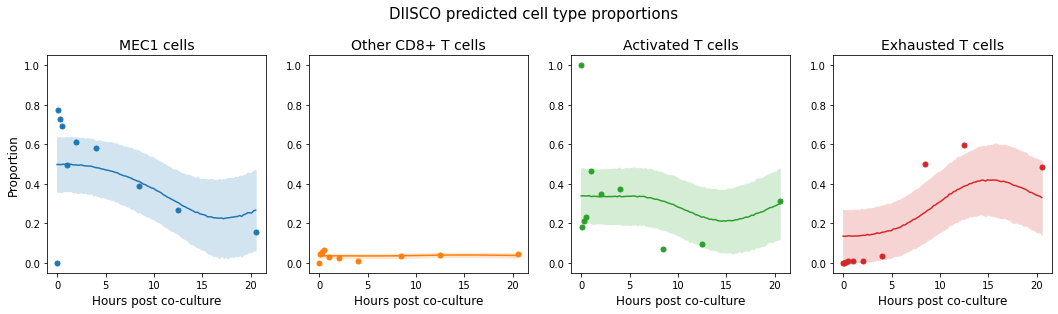

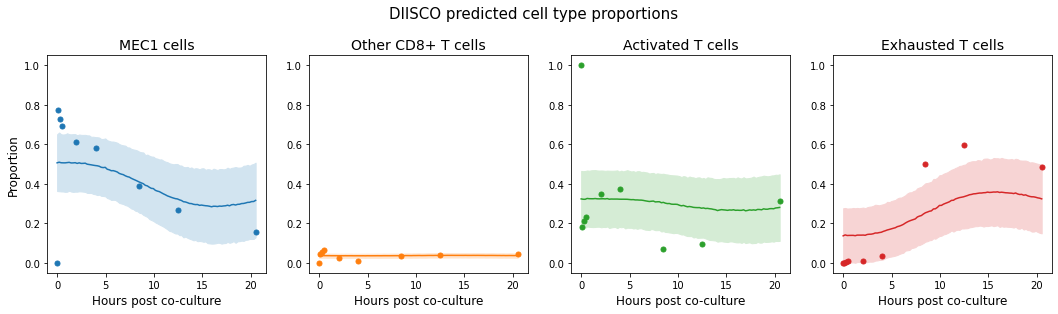

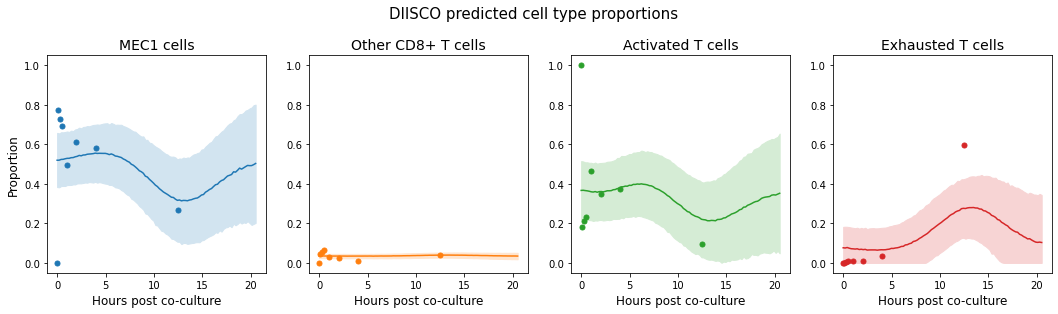

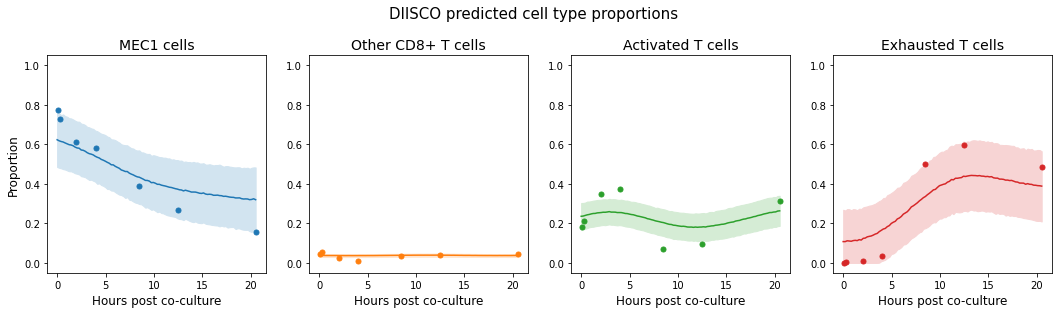

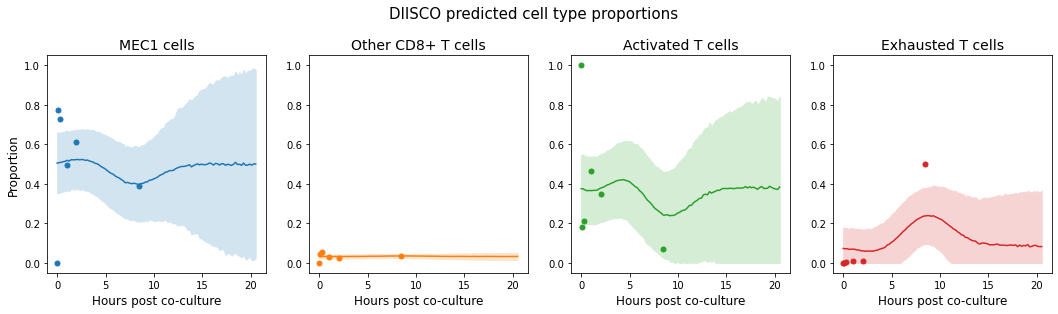

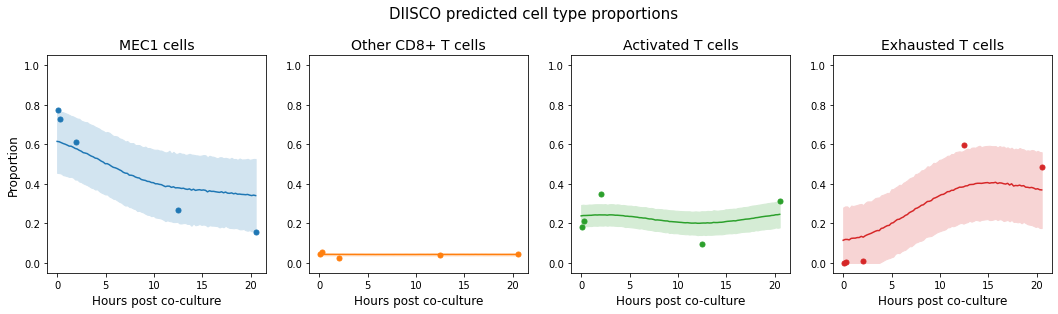

In [20]:
np.random.seed(0)
predictions = {}
for drop_fraction in drop_timepoints_fractions:
    print(drop_fraction)
    num_timepoints_to_keep = int((1 - drop_fraction) * X.shape[0])
    timepoints_to_keep = np.random.choice(np.arange(X.shape[0]), 
                                          size=num_timepoints_to_keep, 
                                          replace=False)
    timepoints = torch.tensor(X[timepoints_to_keep, :])
    proportions = torch.tensor(Y[timepoints_to_keep, :])
    # z score the proportions
    proportions_mean = proportions.mean(dim=0)
    proportions_std = proportions.std(dim=0)
    # proportions = proportions - proportions_mean
    proportions = (proportions - proportions_mean) / (proportions_std)
    prior_matrix = torch.tensor(W_prior_variance)
    
    def unscale(proportions, cluster_index): 
        return np.clip(proportions * 
                       proportions_std.detach().numpy()[cluster_index] + 
                       proportions_mean.detach().numpy()[cluster_index], 
                       0, None)
    
    lengthscale_f = np.mean(np.abs(X[timepoints_to_keep, :] - X[timepoints_to_keep, :].T))
    j = W_prior_variance.sum(axis=1).max()
    lengthscale_W = max([X[timepoints_to_keep, :][i, 0] - X[timepoints_to_keep, :][i-j+1, 0] 
                         for i in range(j-1, X[timepoints_to_keep, :].shape[0])])
    hyper_init_vals = {
        names.LENGTHSCALE_F: lengthscale_f,
        names.LENGTHSCALE_W: lengthscale_W,
        names.SIGMA_F: 0.5,
        names.VARIANCE_F: 1,
        names.SIGMA_W: 0.1,
        names.VARIANCE_W: 1,
        names.SIGMA_Y: 0.5,
    }
    
    model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)
    model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
    model.fit(timepoints, 
              proportions, 
              n_iter=10000, 
              lr=0.00005,
              hypers_to_optim=[], 
              guide="MultivariateNormalFactorized")
    
    predict_timepoints = torch.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    samples = model.sample(predict_timepoints, 
                           n_samples=10000, 
                           n_samples_per_latent=10,
                           include_emission_variance=True)
    
    predictions[drop_fraction] = {
        'W_samples_predict': samples['W'],
        'y_samples_predict': samples['Y']
    }

    cell_type_color = [('MEC1 cells', 'tab:blue'), 
                       ('Other CD8+ T cells', 'tab:orange'), 
                       ('Activated T cells', 'tab:green'),
                       ('Exhausted T cells', 'tab:red')]
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        cell_type_samples = samples['Y'][:, :, i]
        mean = unscale(cell_type_samples.mean(axis=0), i)
        x = predict_timepoints.squeeze().numpy()
        percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
        percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
        ax = axes[i]
        color_with_alpha = list(colors2.to_rgb(cell_type_color[i][1])) + [0.2]
        color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
        line = ax.plot(x, mean, c=cell_type_color[i][1])
        ax.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
        ax.scatter(timepoints, unscale(proportions[:, i], i), c=cell_type_color[i][1], s=25)
        ax.set_title(f'{cell_type_color[i][0]}', fontsize=14)
        ax.set_xlabel('Hours post co-culture', fontsize=12)
        if i==0: ax.set_ylabel('Proportion', fontsize=12)
        ax.set_ylim([-0.05, 1.05])
    plt.suptitle('DIISCO predicted cell type proportions', fontsize=15, y=1.05)
    plt.savefig(f'../../figures/CAR-T/revisions/robustness_timepoints/predicted_proportions_for_downsampled_timepoints_{str(drop_fraction)[:4]}.eps', 
                bbox_inches='tight')

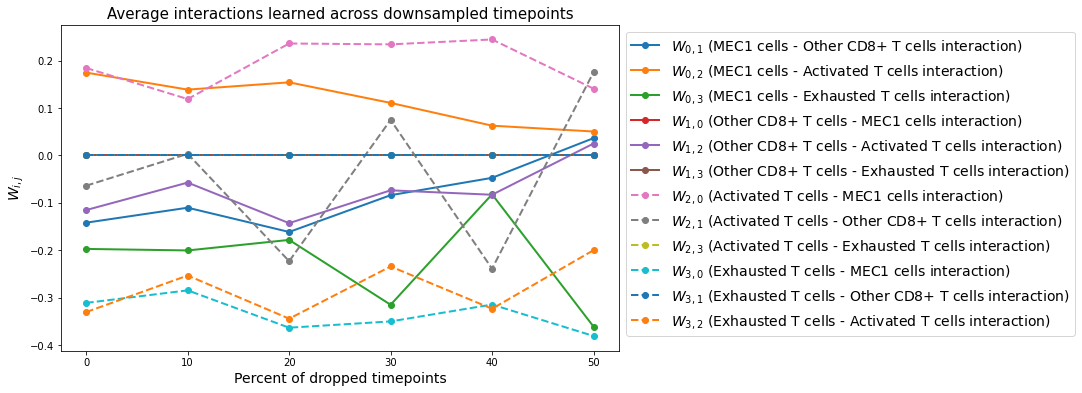

In [21]:
W_avg_over_drop_fractions = np.stack([predictions[drop_fraction]['W_samples_predict'].mean(axis=[0, 1]) 
                                      for drop_fraction in drop_timepoints_fractions])

plt.figure(figsize=(10, 6))
linestyles = ['-', '--']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        if i != j:
            plt.plot((drop_timepoints_fractions * 100).astype(int), 
                     W_avg_over_drop_fractions[:, i, j],
                     linestyle=linestyles[i//2],
                     linewidth=2,
                     marker='o',
                     label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Percent of dropped timepoints', fontsize=14)
plt.title('Average interactions learned across downsampled timepoints', fontsize=15)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_timepoints/W_avg_over_downsampled_timepoints.eps', 
            bbox_inches='tight')

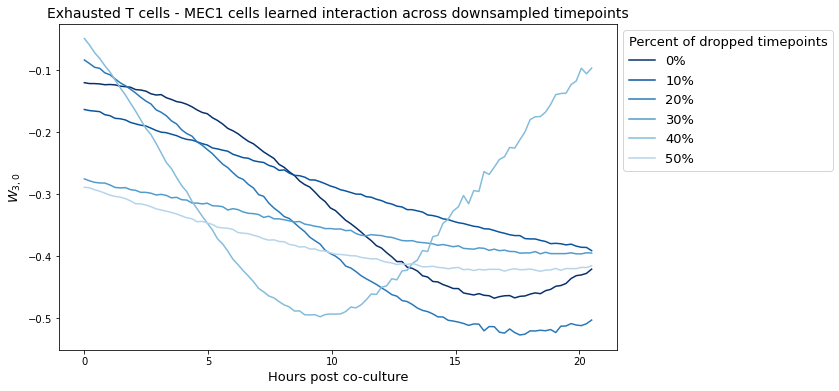

In [22]:
plt.figure(figsize=(10, 6))
cmap = mpl.colormaps['Blues_r']
colors = cmap(np.linspace(0, 0.7, len(drop_timepoints_fractions)))
for i, drop_fraction in enumerate(drop_timepoints_fractions):
    W_exhausted_mec1 = predictions[drop_fraction]['W_samples_predict'].mean(axis=0)[:, 3, 0]
    plt.plot(predict_timepoints, W_exhausted_mec1, 
             label=f'{int(drop_fraction * 100)}%',
             color=colors[i])
plt.ylabel('$W_{3, 0}$', fontsize=13)
plt.xlabel('Hours post co-culture', fontsize=13)
plt.title('Exhausted T cells - MEC1 cells learned interaction across downsampled timepoints', 
          fontsize=14)
leg = plt.legend(title='Percent of dropped timepoints', bbox_to_anchor=(1, 1), loc='upper left',
           fontsize=13, title_fontsize=13)
leg._legend_box.align = "left"
plt.savefig(f'../../figures/CAR-T/revisions/robustness_timepoints/W_exhausted_mec1_over_downsampled_timepoints.eps', 
            bbox_inches='tight')

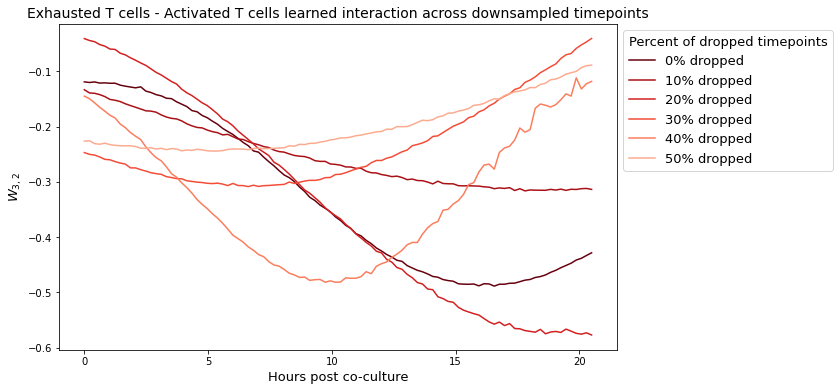

In [23]:
plt.figure(figsize=(10, 6))
cmap = mpl.colormaps['Reds_r']
colors = cmap(np.linspace(0, 0.7, len(drop_timepoints_fractions)))
for i, drop_fraction in enumerate(drop_timepoints_fractions):
    W_exhausted_activated = predictions[drop_fraction]['W_samples_predict'].mean(axis=0)[:, 3, 2]
    plt.plot(predict_timepoints, W_exhausted_activated, 
             label=f'{int(drop_fraction * 100)}% dropped',
             color=colors[i])
plt.ylabel('$W_{3, 2}$', fontsize=13)
plt.xlabel('Hours post co-culture', fontsize=13)
plt.title('Exhausted T cells - Activated T cells learned interaction across downsampled timepoints', 
          fontsize=14)
leg = plt.legend(title='Percent of dropped timepoints', bbox_to_anchor=(1, 1), loc='upper left',
           fontsize=13, title_fontsize=13)
leg._legend_box.align = "left"
plt.savefig(f'../../figures/CAR-T/revisions/robustness_timepoints/W_exhausted_activated_over_downsampled_timepoints.eps', 
            bbox_inches='tight')

## Robustness over clustering resolution

Train DIISCO model on clusters instead of metaclusters

In [24]:
df = pickle.load(open('../data/CAR-T ratios and umap/CAR_T_umap_revised.pkl', "rb"))
df = df[df.index.str.startswith('CARC')]
df['metacluster'] = df['metacluster'].replace([0, 1, 2, 3], cell_types)
df

,x,y,c,cluster_number,metacluster,DATA,time
CARC_T8_AAACCTGAGAAGGCCT,5.567172,0.087582,1.495141,12,Activated T cells,CARC,T8
CARC_T9_AAACCTGAGACAAGCC,1.502741,-0.987649,1.320962,3,Activated T cells,CARC,T9
CARC_T6_AAACCTGAGACAATAC,4.663743,-0.975110,0.492641,3,Activated T cells,CARC,T6
CARC_T9_AAACCTGAGCCATCGC,15.180671,4.691824,-2.302585,10,MEC1 cells,CARC,T9
CARC_T2_AAACCTGAGGTAGCTG,13.630413,2.641607,-0.990700,17,MEC1 cells,CARC,T2
...,...,...,...,...,...,...,...
CARC_T6_TTTGTCATCCGATATG,13.910586,1.207425,-0.153010,5,NaN,CARC,T6
CARC_T9_TTTGTCATCGACGGAA,11.207350,-3.329571,1.203709,15,Exhausted T cells,CARC,T9
CARC_T9_TTTGTCATCGGCTTGG,11.399427,-4.040952,1.123553,15,Exhausted T cells,CARC,T9
CARC_T7_TTTGTCATCGTGGGAA,6.844381,-2.513008,1.062368,9,Exhausted T cells,CARC,T7


In [25]:
# Drop cells not in MCs
df = df.dropna(subset=['metacluster'])

# Drop clusters with < 100 cells
cluster_counts = df['cluster_number'].value_counts()
drop_clusters = cluster_counts.index[cluster_counts < 100]
df = df[~df['cluster_number'].isin(drop_clusters)]

df

,x,y,c,cluster_number,metacluster,DATA,time
CARC_T8_AAACCTGAGAAGGCCT,5.567172,0.087582,1.495141,12,Activated T cells,CARC,T8
CARC_T9_AAACCTGAGACAAGCC,1.502741,-0.987649,1.320962,3,Activated T cells,CARC,T9
CARC_T6_AAACCTGAGACAATAC,4.663743,-0.975110,0.492641,3,Activated T cells,CARC,T6
CARC_T9_AAACCTGAGCCATCGC,15.180671,4.691824,-2.302585,10,MEC1 cells,CARC,T9
CARC_T2_AAACCTGAGGTAGCTG,13.630413,2.641607,-0.990700,17,MEC1 cells,CARC,T2
...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,12.010520,4.462165,-2.302585,17,MEC1 cells,CARC,T9
CARC_T9_TTTGTCATCGACGGAA,11.207350,-3.329571,1.203709,15,Exhausted T cells,CARC,T9
CARC_T9_TTTGTCATCGGCTTGG,11.399427,-4.040952,1.123553,15,Exhausted T cells,CARC,T9
CARC_T7_TTTGTCATCGTGGGAA,6.844381,-2.513008,1.062368,9,Exhausted T cells,CARC,T7


In [26]:
df['cluster_number'].value_counts()

9     1764
15    1565
3     1331
10    1237
17     903
23     749
12     721
28     339
22     237
26     236
Name: cluster_number, dtype: int64

In [27]:
num_cells_per_cluster_over_time = df.pivot_table(index='time', columns='cluster_number', 
                                                 values='DATA', aggfunc='count')
num_cells_per_cluster_over_time = num_cells_per_cluster_over_time.fillna(0)

cluster_proportions_over_time = num_cells_per_cluster_over_time.\
                                    divide(num_cells_per_cluster_over_time.sum(axis=1),
                                           axis=0)
cluster_proportions_over_time.index = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
cluster_proportions_over_time

cluster_number,3,9,10,12,15,17,22,23,26,28
0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.083333,0.169811,0.000000,0.594340,0.009434,0.000000,0.084906,0.047170,0.047170,0.000000,0.047170
0.250000,0.213953,0.004651,0.572093,0.000000,0.000000,0.079070,0.051163,0.027907,0.000000,0.051163
0.500000,0.232432,0.000000,0.545946,0.005405,0.000000,0.075676,0.043243,0.027027,0.010811,0.059459
1.000000,0.357303,0.002247,0.402247,0.105618,0.002247,0.053933,0.035955,0.004494,0.004494,0.031461
2.000000,0.105860,0.003781,0.480151,0.240076,0.000000,0.069943,0.041588,0.026465,0.005671,0.026465
4.000000,0.026066,0.013033,0.206161,0.347156,0.001185,0.219194,0.033175,0.129147,0.014218,0.010664
8.500000,0.052126,0.445850,0.045040,0.019737,0.024798,0.172571,0.019231,0.153340,0.030870,0.036437
12.500000,0.080276,0.366826,0.027113,0.013291,0.195641,0.094631,0.021265,0.121744,0.036151,0.043062
20.500000,0.251898,0.061422,0.070048,0.064872,0.395445,0.033816,0.023810,0.026225,0.030366,0.042098


In [28]:
cluster_proportions_over_time.sum(axis=1)

0.000000     1.0
0.083333     1.0
0.250000     1.0
0.500000     1.0
1.000000     1.0
2.000000     1.0
4.000000     1.0
8.500000     1.0
12.500000    1.0
20.500000    1.0
dtype: float64

In [29]:
timepoints_unique = sorted(df['time'].unique())
clusters_unique = sorted(df['cluster_number'].unique())

In [30]:
metacluster_to_color = {
    'MEC1 cells': 'tab:blue', 
    'Other CD8+ T cells': 'tab:orange', 
    'Activated T cells': 'tab:green',
    'Exhausted T cells': 'tab:red'
}

metacluster_to_clusters = {
    metacluster: df.loc[df['metacluster'] == metacluster, 'cluster_number'].unique()
    for metacluster in cell_types
}

cluster_to_metacluster = {
    cluster: metacluster
    for metacluster, clusters in metacluster_to_clusters.items() 
    for cluster in clusters
}
cluster_to_metacluster

{10: 'MEC1 cells',
 17: 'MEC1 cells',
 23: 'MEC1 cells',
 22: 'MEC1 cells',
 28: 'Other CD8+ T cells',
 12: 'Activated T cells',
 3: 'Activated T cells',
 15: 'Exhausted T cells',
 9: 'Exhausted T cells',
 26: 'Exhausted T cells'}

In [31]:
metacluster_to_clusters

{'MEC1 cells': array([10, 17, 23, 22]),
 'Other CD8+ T cells': array([28]),
 'Activated T cells': array([12,  3]),
 'Exhausted T cells': array([15,  9, 26])}

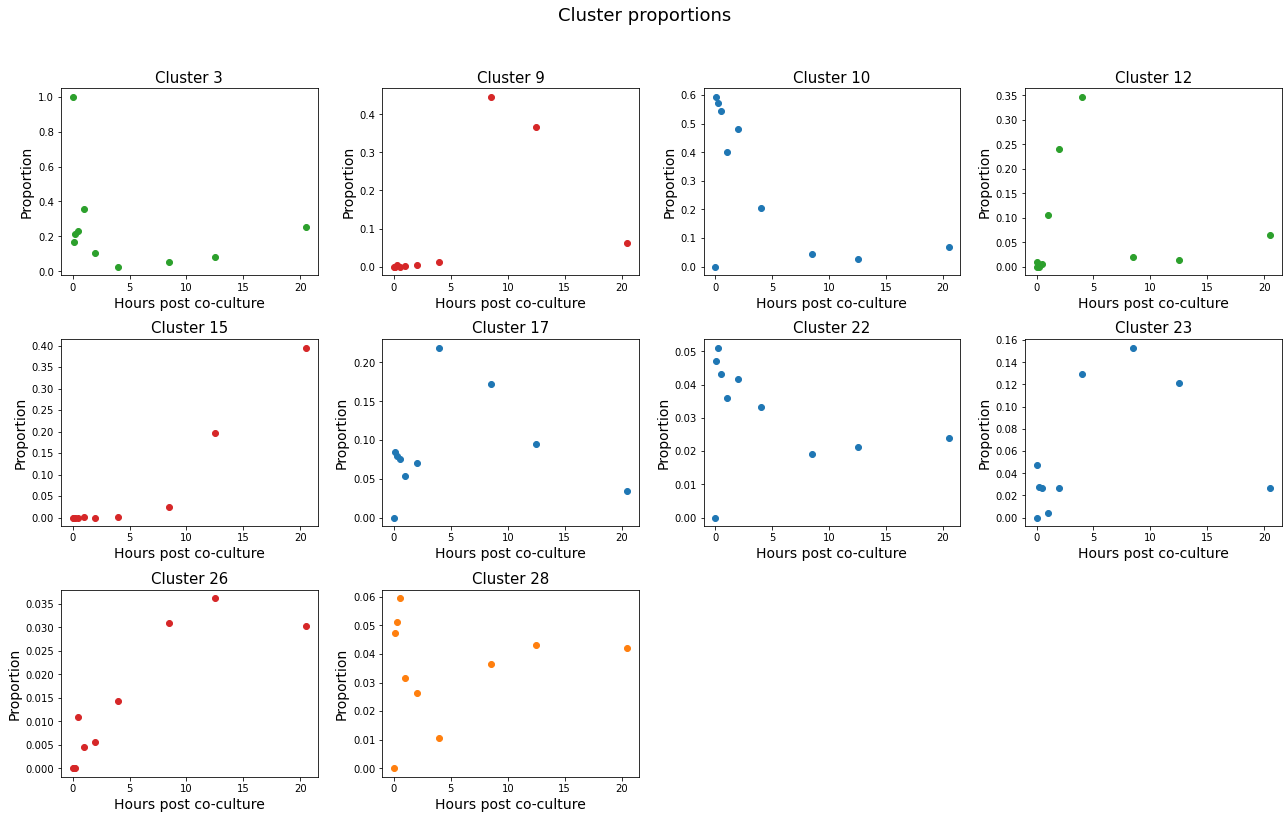

In [32]:
plt.figure(figsize=(18, 11))
for i, cluster in enumerate(clusters_unique):
    metacluster = cluster_to_metacluster[cluster]
    color = metacluster_to_color[metacluster]
    plt.subplot(3, 4, i+1)
    plt.scatter(cluster_proportions_over_time.index, 
                cluster_proportions_over_time[cluster], 
                color=color)
    plt.title(f'Cluster {cluster}', fontsize=15)
    plt.ylabel('Proportion', fontsize=14)
    plt.xlabel('Hours post co-culture', fontsize=14)
plt.suptitle(f'Cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_resolution/cluster_proportions.eps', 
            bbox_inches='tight')

In [33]:
hours_post_coculture = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
hours_post_coculture = {i: hour for i, hour in enumerate(hours_post_coculture)}

gene_exp_df = pickle.load(open('../../data/CAR-T ratios and umap/data_df_revised_clusters.pkl', 'rb'))

# Filter to experiment
gene_exp_df = gene_exp_df[gene_exp_df.index.str.startswith('CARC')]
gene_exp_df = gene_exp_df[gene_exp_df['cluster_number'].isin(clusters_unique)]
gene_exp_df['timestamp'] = [int(index_split[1][1]) 
                            for index_split in gene_exp_df.index.str.split('_')]
gene_exp_df['timestamp'] = gene_exp_df['timestamp'].replace(hours_post_coculture)
genes = gene_exp_df.columns[:-2]
gene_exp_df

,MIR1302-2HG,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,SAMD11,NOC2L,...,AC145212.1,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC233755.1,AC240274.1,cluster_number,timestamp
CARC_T8_AAACCTGAGAAGGCCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,12.50
CARC_T9_AAACCTGAGACAAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,20.50
CARC_T6_AAACCTGAGACAATAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,4.00
CARC_T9_AAACCTGAGCCATCGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.633307,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10,20.50
CARC_T2_AAACCTGAGGTAGCTG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.990700,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,20.50
CARC_T9_TTTGTCATCGACGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.445403,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,20.50
CARC_T9_TTTGTCATCGGCTTGG,-2.302585,-2.302585,-2.302585,-2.302585,-0.744831,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,20.50
CARC_T7_TTTGTCATCGTGGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9,8.50


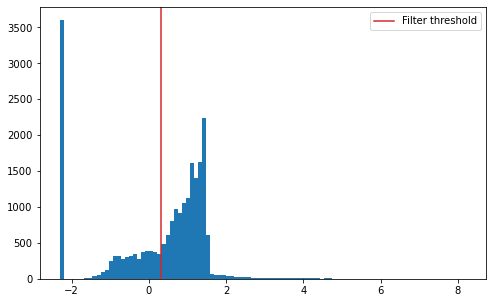

In [34]:
threshold = 0.3

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df[genes].max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [35]:
print("Percent genes removed:", (gene_exp_df[genes].max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df[genes].max() <= threshold)
genes = genes[~gene_filter]
gene_exp_df = gene_exp_df.drop(columns=gene_filter[gene_filter].index)
gene_exp_df

Percent genes removed: 36.55243563290572


,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,PERM1,ISG15,AGRN,C1orf159,...,MT-ND5,MT-ND6,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,cluster_number,timestamp
CARC_T8_AAACCTGAGAAGGCCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,1.525979,0.202868,3.453078,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,12.50
CARC_T9_AAACCTGAGACAAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,1.320962,-2.302585,3.312464,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,20.50
CARC_T6_AAACCTGAGACAATAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.117269,-2.302585,-2.302585,...,0.764930,-0.490678,2.670134,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,4.00
CARC_T9_AAACCTGAGCCATCGC,-2.302585,-2.302585,-2.302585,-0.633307,-2.302585,-2.302585,-2.302585,-0.039088,-2.302585,-2.302585,...,1.662030,-0.039088,3.094332,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10,20.50
CARC_T2_AAACCTGAGGTAGCTG,-2.302585,-2.302585,-2.302585,-0.990700,-2.302585,-2.302585,-2.302585,0.169968,-2.302585,-2.302585,...,2.040814,-0.442180,3.253281,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.648138,-2.302585,-2.302585,...,1.867426,-2.302585,3.882065,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,20.50
CARC_T9_TTTGTCATCGACGGAA,-2.302585,-2.302585,-2.302585,-0.445403,-2.302585,-2.302585,-2.302585,-0.445403,-2.302585,-2.302585,...,2.199371,-0.093378,3.040313,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,20.50
CARC_T9_TTTGTCATCGGCTTGG,-2.302585,-0.744831,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.744831,-2.302585,-2.302585,...,2.248167,0.202486,3.150104,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,15,20.50
CARC_T7_TTTGTCATCGTGGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,2.077422,-2.302585,3.247368,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9,8.50


In [36]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])

# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
7,P05019,P08069,IGF1,IGF1R,True,True,False,True,True,False,27,Baccin2019:1852007;Baccin2019:2877871;CA1:8408...,Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...,11287679;12067807;14604834;185;1852007;1902995...,15,42,26
8,P46531,P78504,NOTCH1,JAG1,True,True,False,False,False,False,16,Baccin2019:11006133;BioGRID:11006133;DIP:18660...,Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntA...,11006133;16713569;17537801;18495817;18660822;2...,9,14,13
9,P78504,P46531,JAG1,NOTCH1,True,True,True,True,True,False,36,ACSN:22330899;ACSN:22363130;Baccin2019:7697721...,ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;Ce...,10958687;11;11006133;15137944;16713569;1692140...,20,39,27
15,Q9GZX6,Q08334,IL22,IL10RB,True,True,False,True,True,False,12,CellTalkDB:10875937;HPRD:10875937;LRdb:1087593...,CellCall;CellTalkDB;Fantom5_LRdb;Guide2Pharma;...,10875937;12513909;15120653;17208301;18509351;2...,6,20,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296,Q01974,Q9NPG1,ROR2,FZD3,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8297,P34925,Q9NPG1,RYK,FZD3,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8304,Q01974,O60353,ROR2,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8305,P34925,O60353,RYK,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1


In [37]:
sample_to_cluster_to_degs = dict()

for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):
    print(timestamp)
    sample_to_cluster_to_degs[timestamp] = dict()
    sample_gene_exp_df = gene_exp_df[(gene_exp_df['timestamp'] == timestamp) & 
                                     (gene_exp_df['cluster_number'].isin(clusters_unique))]
    clusters_with_more_than_1_cell = sample_gene_exp_df['cluster_number'].value_counts()\
                                        [sample_gene_exp_df['cluster_number'].value_counts() > 1].index
    sample_gene_exp_df = sample_gene_exp_df[sample_gene_exp_df['cluster_number'].isin(clusters_with_more_than_1_cell)]
    if sample_gene_exp_df.shape[0] == 0: continue
    sample_adata = sc.AnnData(sample_gene_exp_df[genes], 
                              obs=sample_gene_exp_df[['cluster_number']].astype('str'))
    sc.tl.rank_genes_groups(sample_adata, groupby='cluster_number', method='wilcoxon', key_added='wilcoxon')
    for cluster in clusters_unique:
        if cluster not in clusters_with_more_than_1_cell: 
            sample_to_cluster_to_degs[timestamp][cluster] = []
            continue
        sample_cluster_deg_df = sc.get.rank_genes_groups_df(sample_adata, group=str(cluster), key='wilcoxon')
        top_degs = sample_cluster_deg_df[(sample_cluster_deg_df['pvals_adj'] <= 0.01) & 
                                         (sample_cluster_deg_df['scores'] >= 0)]
        sample_to_cluster_to_degs[timestamp][cluster] = list(zip(top_degs['names'], top_degs['scores']))

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_99417/1841455938.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):


  0%|          | 0/10 [00:00<?, ?it/s]

12.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

20.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

4.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.25


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

2.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

8.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

1.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.08333333333333333
0.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: Mean of empty slice.
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:324: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (


In [38]:
def create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, rl_pairs, clusters_of_interest, 
                                             sample_to_cluster_to_degs):
    sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
    sample_cluster_avg_gene_exp = sample_gene_exp_df.groupby('cluster_number').mean()
    cluster_interaction_score_matrix = np.full((len(clusters_of_interest), len(clusters_of_interest)), 
                                               np.nan)
    for row, receiver_cluster in enumerate(clusters_of_interest):
        for col, sender_cluster in enumerate(clusters_of_interest):
            if (receiver_cluster in sample_cluster_avg_gene_exp.index and 
                sender_cluster in sample_cluster_avg_gene_exp.index):
                ligand_gene_expressions = sample_cluster_avg_gene_exp.loc[sender_cluster][rl_pairs['source_genesymbol']]
                receptor_gene_expressions = sample_cluster_avg_gene_exp.loc[receiver_cluster][rl_pairs['target_genesymbol']]
                # Filter down to highly co-expressed and differentially-expressed RL pairs
                sample_sender_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][sender_cluster]]
                sample_receiver_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][receiver_cluster]]
                rl_interaction_thresholded = \
                    (ligand_gene_expressions.index.isin(sample_sender_cluster_degs) & 
                     receptor_gene_expressions.index.isin(sample_receiver_cluster_degs))
                cluster_interaction_score_matrix[row][col] = rl_interaction_thresholded.sum()
    return cluster_interaction_score_matrix

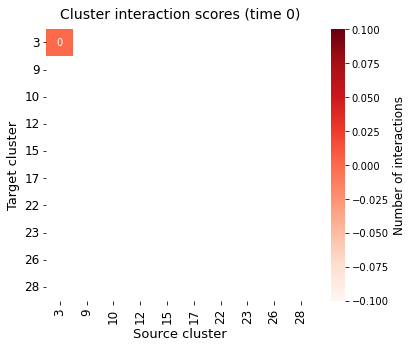

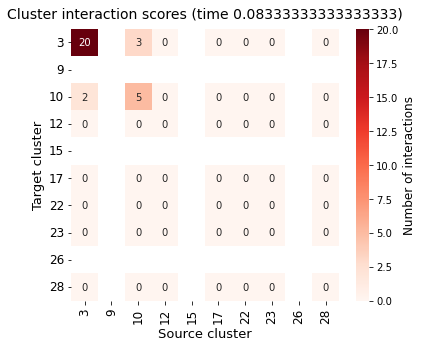

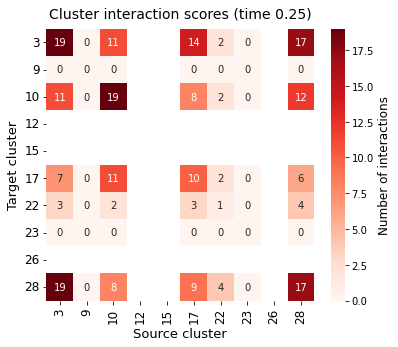

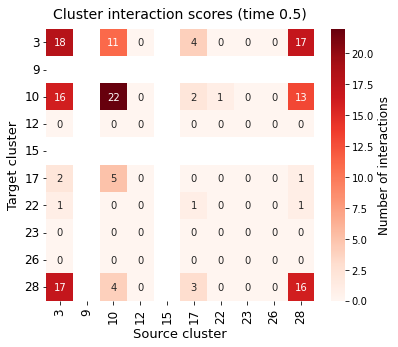

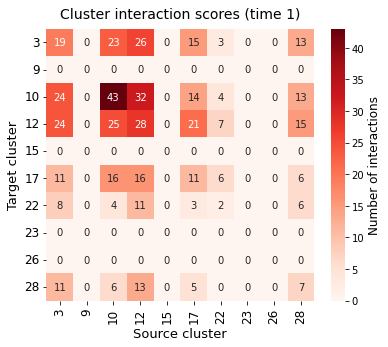

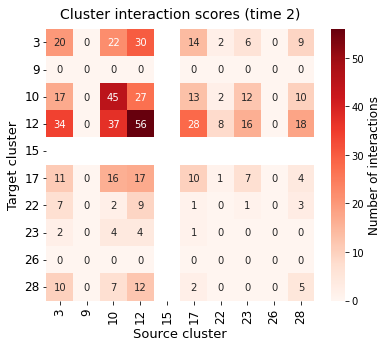

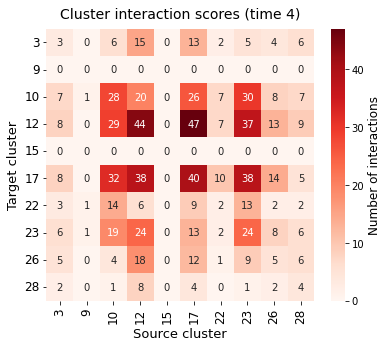

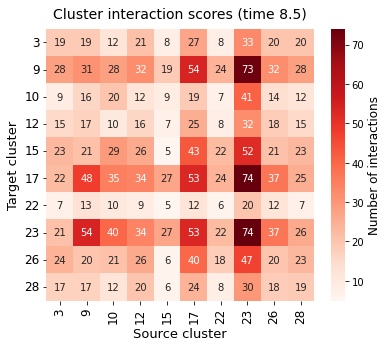

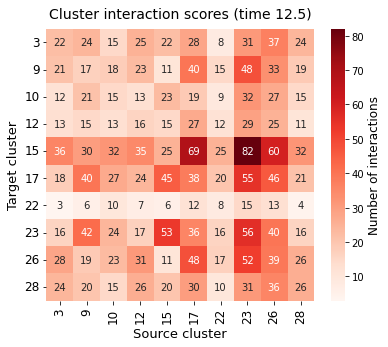

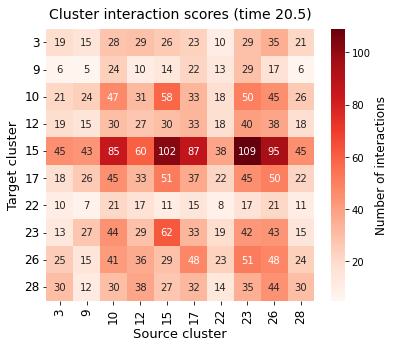

In [39]:
sample_cluster_interaction_score_matrices = {}

for timestamp in hours_post_coculture.values():
    cluster_interaction_score_matrix = create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, 
                                            rl_pairs, clusters_unique, sample_to_cluster_to_degs)
    sample_cluster_interaction_score_matrices[timestamp] = cluster_interaction_score_matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cluster_interaction_score_matrix, cmap="Reds", annot=True, fmt='.0f', 
                     cbar_kws={'label': 'Number of interactions'})
    ax.figure.axes[-1].yaxis.label.set_size(12)
    ax.set_yticklabels(clusters_unique, rotation=0, fontsize=12)
    ax.set_xticklabels(clusters_unique, rotation=90, fontsize=12)
    plt.xlabel('Source cluster', fontsize=13)
    plt.ylabel('Target cluster', fontsize=13)
    plt.title(f'Cluster interaction scores (time {timestamp})', fontsize=14, y=1.02)

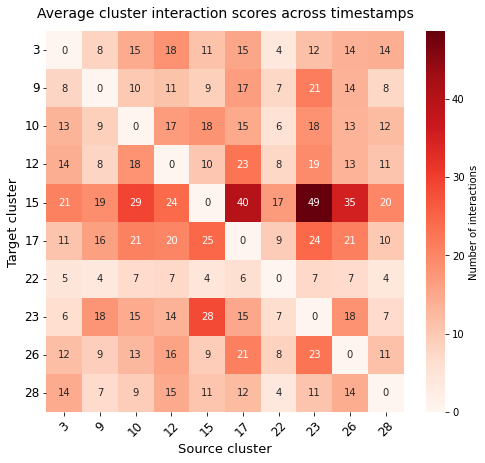

In [40]:
avg_cluster_interaction_score = np.nanmean(
    np.array(list(sample_cluster_interaction_score_matrices.values())), 
    axis=0)
np.fill_diagonal(avg_cluster_interaction_score, 0)

plt.figure(figsize=(8, 7))
ax = sns.heatmap(avg_cluster_interaction_score, cmap="Reds", 
                 annot=True, fmt='.0f', cbar_kws={'label': 'Number of interactions'})
ax.set_yticklabels(clusters_unique, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_unique, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Average cluster interaction scores across timestamps', fontsize=14, y=1.02)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_resolution/interaction_scores.eps', 
            bbox_inches='tight')

Text(0.5, 1.0, 'Distribution of average interaction scores')

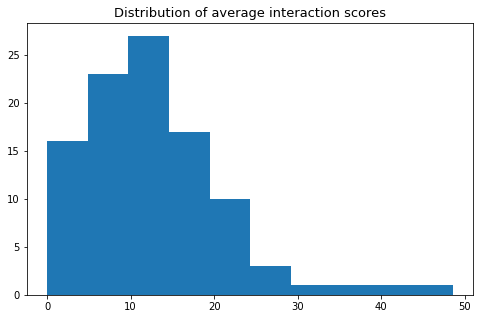

In [41]:
plt.figure(figsize=(8, 5))
plt.hist(avg_cluster_interaction_score.flatten(), bins=10)
plt.title('Distribution of average interaction scores', fontsize=13)

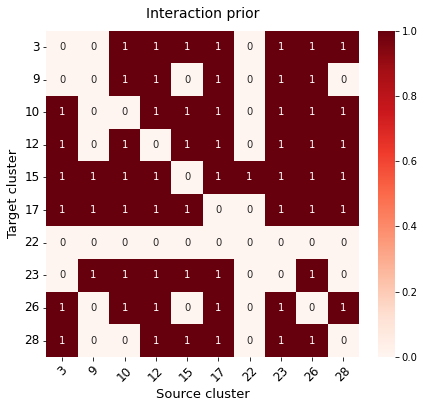

In [42]:
interaction_prior = avg_cluster_interaction_score >= 10

plt.figure(figsize=(7, 6))
ax = sns.heatmap(interaction_prior, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_unique, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_unique, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Interaction prior', fontsize=14, y=1.02)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_resolution/interaction_prior.eps', 
            bbox_inches='tight')

In [43]:
X = cluster_proportions_over_time.index.values.reshape(-1, 1)
X

array([[ 0.        ],
       [ 0.08333333],
       [ 0.25      ],
       [ 0.5       ],
       [ 1.        ],
       [ 2.        ],
       [ 4.        ],
       [ 8.5       ],
       [12.5       ],
       [20.5       ]])

In [44]:
Y = cluster_proportions_over_time.values
Y

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16981132, 0.        , 0.59433962, 0.00943396, 0.        ,
        0.08490566, 0.04716981, 0.04716981, 0.        , 0.04716981],
       [0.21395349, 0.00465116, 0.57209302, 0.        , 0.        ,
        0.07906977, 0.05116279, 0.02790698, 0.        , 0.05116279],
       [0.23243243, 0.        , 0.54594595, 0.00540541, 0.        ,
        0.07567568, 0.04324324, 0.02702703, 0.01081081, 0.05945946],
       [0.35730337, 0.00224719, 0.40224719, 0.10561798, 0.00224719,
        0.05393258, 0.03595506, 0.00449438, 0.00449438, 0.03146067],
       [0.10586011, 0.00378072, 0.48015123, 0.24007561, 0.        ,
        0.06994329, 0.0415879 , 0.02646503, 0.00567108, 0.02646503],
       [0.02606635, 0.01303318, 0.20616114, 0.3471564 , 0.00118483,
        0.21919431, 0.03317536, 0.12914692, 0.01421801, 0.01066351],
       [0.05212551, 0.4458502 , 0.0450404

In [45]:
t_subset_num = 12
timepoints = torch.tensor(X)[:t_subset_num]
proportions = torch.tensor(Y)[:t_subset_num]
prior_matrix = torch.tensor(interaction_prior)
n_timepoints, n_cell_types = proportions.shape

# z score the proportions
proportions_mean = proportions.mean(dim=0)
proportions_std = proportions.std(dim=0)
# proportions = proportions - proportions_mean
proportions = (proportions - proportions_mean)/ (proportions_std)
#proportions = proportions / proportions_std


print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([10, 1])
cell_types.shape: torch.Size([10, 10])


In [46]:
def unscale(proportions, cluster_index): 
    return np.clip(proportions * 
                   proportions_std.detach().numpy()[cluster_index] + 
                   proportions_mean.detach().numpy()[cluster_index], 
                   0, None)

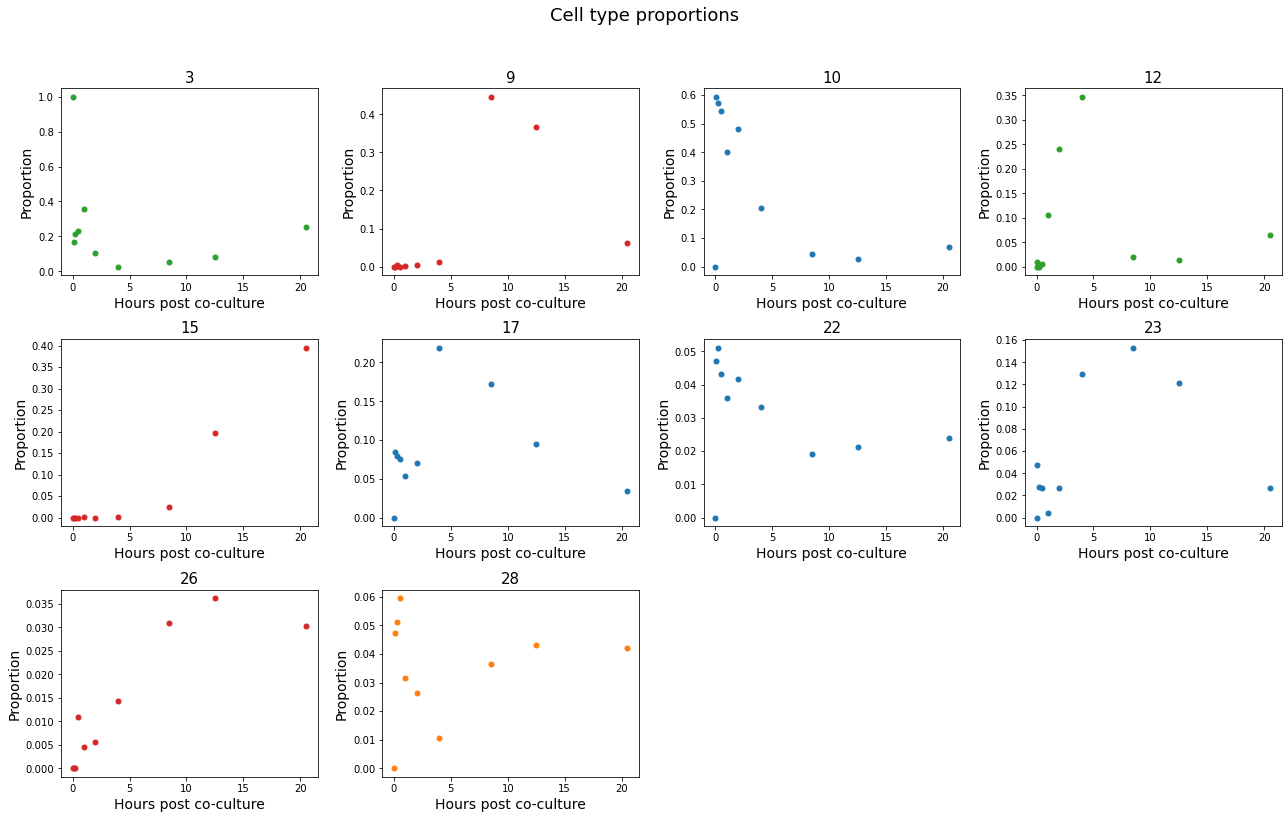

In [47]:
plt.figure(figsize=(18, 11))
for i, cluster in enumerate(clusters_unique):
    metacluster = cluster_to_metacluster[cluster]
    color = metacluster_to_color[metacluster]
    plt.subplot(3, 4, i+1)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=25)
    plt.title(f'{cluster}', fontsize=15)
    plt.ylabel('Proportion', fontsize=14)
    plt.xlabel('Hours post co-culture', fontsize=14)
plt.suptitle('Cell type proportions', fontsize=18, y=1.03)
plt.tight_layout()

In [48]:
# mean of all intervals
lengthscale_f = np.mean(np.abs(X - X.T))
lengthscale_f

6.483333333333333

In [49]:
j = interaction_prior.sum(axis=1).max()
lengthscale_W = max([X[i, 0] - X[i-j+1, 0] 
                     for i in range(j-1, X.shape[0])])
lengthscale_W

20.416666666666668

In [50]:
hyper_init_vals = {
    names.LENGTHSCALE_F: lengthscale_f,
    names.LENGTHSCALE_W: lengthscale_W,
    names.SIGMA_F: 0.5,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.5,
}
print(hyper_init_vals)

{'lengthscale_f': 6.483333333333333, 'lengthscale_w': 20.416666666666668, 'sigma_f': 0.5, 'variance_f': 1, 'sigma_w': 0.1, 'variance_w': 1, 'sigma_y': 0.5}


In [51]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

In [52]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)

In [53]:
model.fit(timepoints, 
          proportions, 
          n_iter=10000, 
          lr=0.00005,
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 101760.3757
[iteration 0101] loss: 52663.4970
[iteration 0201] loss: 47957.0449
[iteration 0301] loss: 45947.6043
[iteration 0401] loss: 43034.9910
[iteration 0501] loss: 41772.1288
[iteration 0601] loss: 40450.1378
[iteration 0701] loss: 40742.7558
[iteration 0801] loss: 38211.9069
[iteration 0901] loss: 37782.5508
[iteration 1001] loss: 37775.7186
[iteration 1101] loss: 36737.9695
[iteration 1201] loss: 35917.1275
[iteration 1301] loss: 35546.5922
[iteration 1401] loss: 34176.0626
[iteration 1501] loss: 34025.8629
[iteration 1601] loss: 33175.9654
[iteration 1701] loss: 33199.9076
[iteration 1801] loss: 32271.6040
[iteration 1901] loss: 31652.4056
[iteration 2001] loss: 32612.9800
[iteration 2101] loss: 31646.3083
[iteration 2201] loss: 31501.5279
[iteration 2301] loss: 31232.8045
[iteration 2401] loss: 30745.3533
[iteration 2501] loss: 30180.3677
[iteration 2601] loss: 30088.1272
[iteration 2701] loss: 29741.2752
[iteration 2801] loss: 29308.7687
[iteration 29

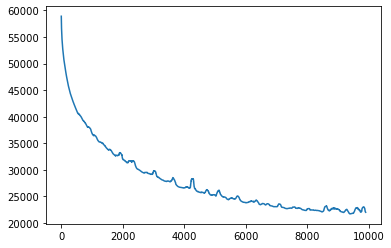

In [54]:
start = 0
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

Text(0.5, 0.95, 'DIISCO y samples')

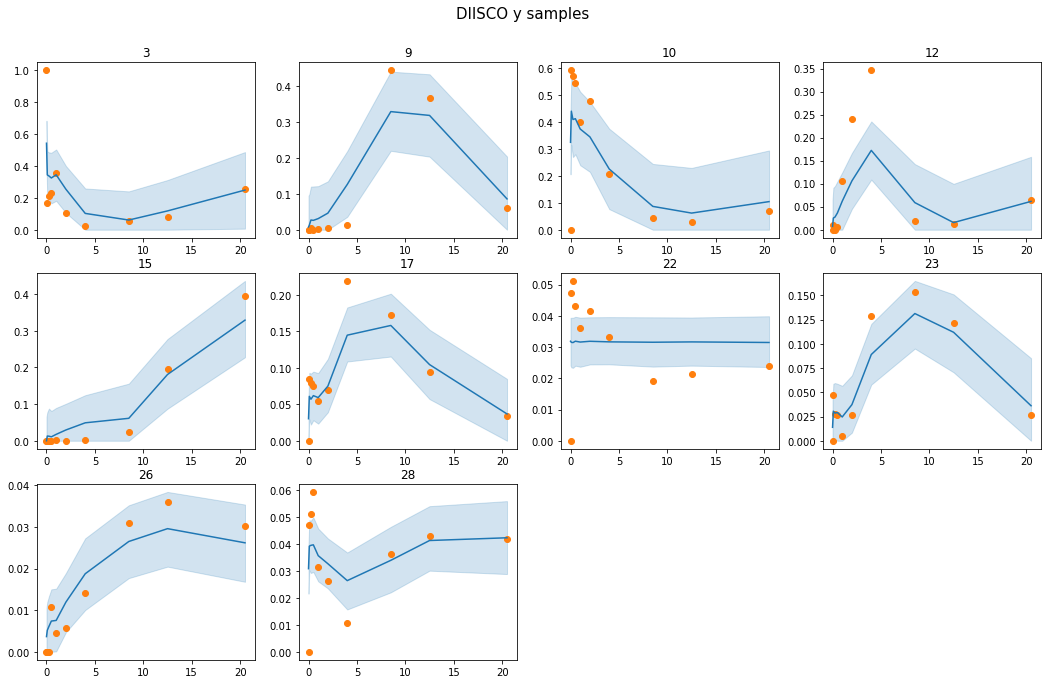

In [55]:
y = model.sample_observed_proportions(n_samples=1000).detach()

plt.figure(figsize=(18, 11))
for i, cluster in enumerate(clusters_unique):
    cell_type_samples = y[:, :, i]
    metacluster = cluster_to_metacluster[cluster]
    color = metacluster_to_color[metacluster]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(3, 4, i+1)
    plt.plot(timepoints, mean, c='tab:blue')
    plt.fill_between(timepoints.squeeze(), percentile_25, percentile_75, color='tab:blue', alpha=0.2)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c='tab:orange')
    plt.title(clusters_unique[i])

plt.suptitle('DIISCO y samples', fontsize=15, y=0.95)

In [56]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                       n_samples=10000, 
                       n_samples_per_latent=10,
                       include_emission_variance=True)

100%|████████████████████████████████████| 10000/10000 [01:33<00:00, 106.63it/s]


In [57]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

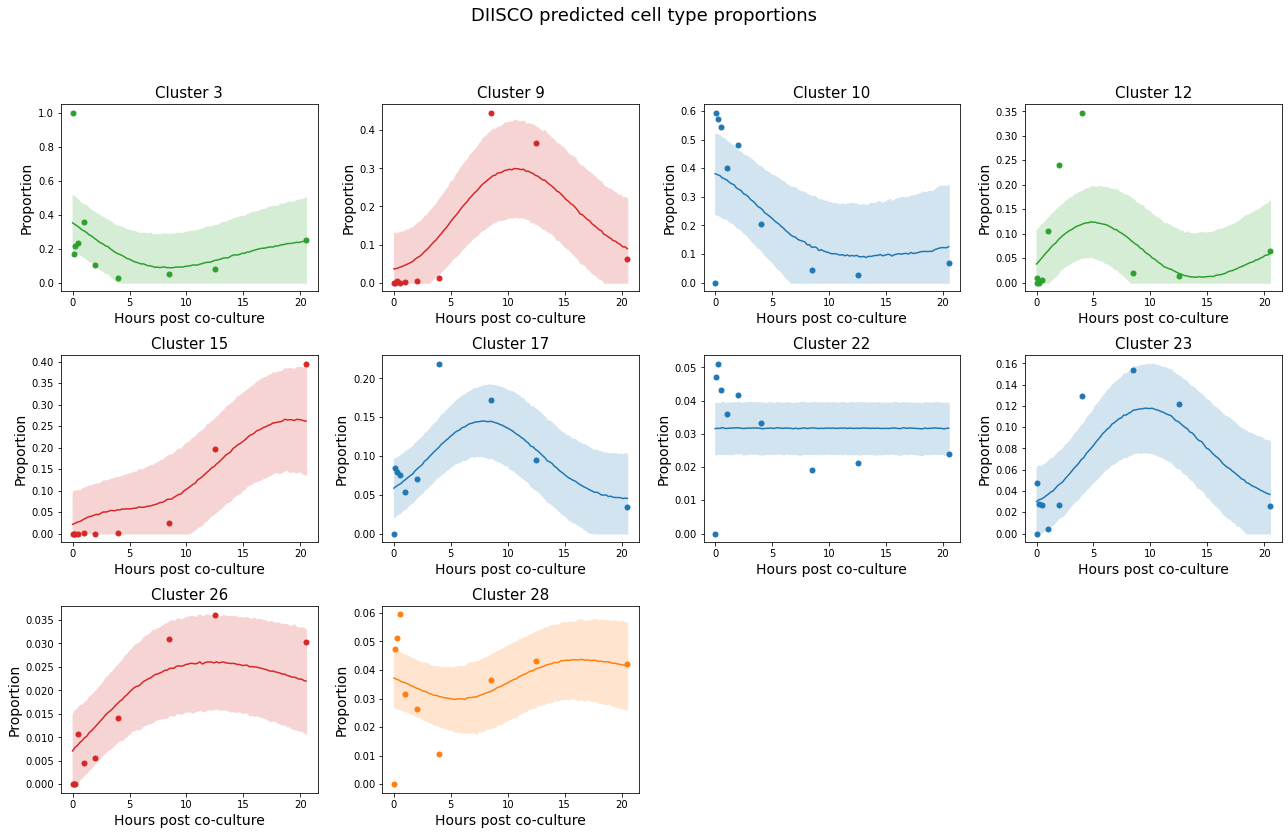

In [58]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors

plt.figure(figsize=(18, 11))
for i, y_i in enumerate(Y.T):
    metacluster = cluster_to_metacluster[clusters_unique[i]]
    color = metacluster_to_color[metacluster]
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze().numpy()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    color_with_alpha = list(colors.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.subplot(3, 4, i+1)
    line = plt.plot(x, mean, c=color)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=25)
    plt.title(f'Cluster {clusters_unique[i]}', fontsize=15)
    plt.xlabel('Hours post co-culture', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
#     plt.ylim([-0.05, 1.05])
plt.suptitle('DIISCO predicted cell type proportions', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_resolution/predicted_proportions.eps', 
            bbox_inches='tight')

Text(0.5, 1.05, 'DIISCO predicted interactions ($\\hat{W}_{avg})$')

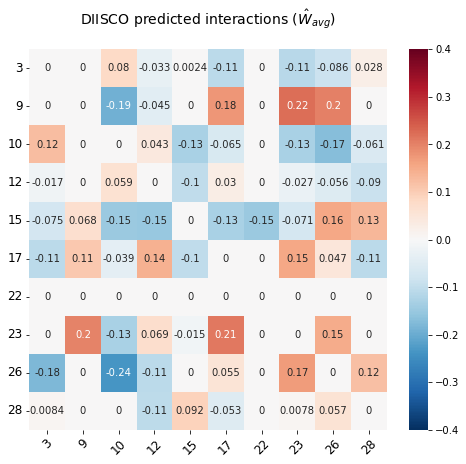

In [59]:
plt.figure(figsize=(8, 7))
W_avg_over_time = W_samples_predict.mean(axis=(0, 1)).detach().numpy()
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmax=0.4, vmin=-0.4, center=0)
ax.set_yticklabels(clusters_unique, fontsize=12)
ax.set_xticklabels(clusters_unique, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('DIISCO predicted interactions ($\hat{W}_{avg})$', fontsize=14, y=1.05)

In [60]:
metacluster_to_clusters

{'MEC1 cells': array([10, 17, 23, 22]),
 'Other CD8+ T cells': array([28]),
 'Activated T cells': array([12,  3]),
 'Exhausted T cells': array([15,  9, 26])}

In [61]:
clusters_rearranged = np.concatenate(list(metacluster_to_clusters.values()))
clusters_rearranged_indices = [clusters_unique.index(cluster) 
                               for cluster in clusters_rearranged]
print(clusters_rearranged)
print(clusters_rearranged_indices)

[10 17 23 22 28 12  3 15  9 26]
[2, 5, 7, 6, 9, 3, 0, 4, 1, 8]


In [62]:
W_avg_over_time_rearranged = W_avg_over_time[:, clusters_rearranged_indices]
W_avg_over_time_rearranged = W_avg_over_time_rearranged[clusters_rearranged_indices, :]
W_avg_over_time_rearranged.shape

(10, 10)

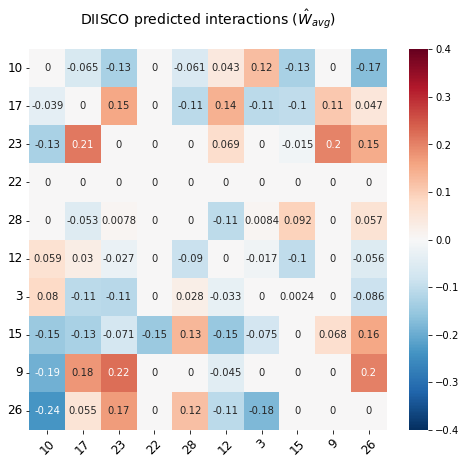

In [63]:
plt.figure(figsize=(8, 7))
ax = sns.heatmap(W_avg_over_time_rearranged, cmap="RdBu_r", annot=True, 
                 vmax=0.4, vmin=-0.4, center=0)
ax.set_yticklabels(clusters_rearranged, fontsize=12)
ax.set_xticklabels(clusters_rearranged, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('DIISCO predicted interactions ($\hat{W}_{avg})$', fontsize=14, y=1.05)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_resolution/W_avg.eps', 
            bbox_inches='tight')

In [64]:
W = W_samples_predict.mean(axis=0)
W.shape

torch.Size([100, 10, 10])

In [65]:
mean_abs_W_threshold = 0.2
max_abs_W_threshold = 0.2

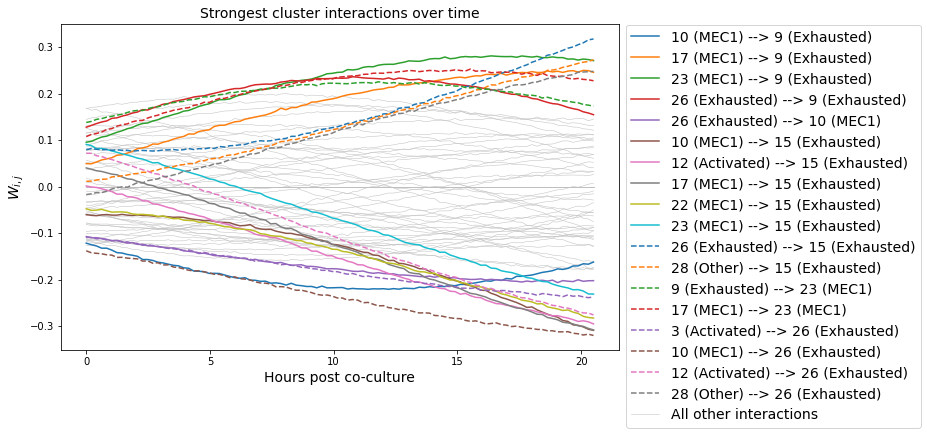

In [66]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_unique):
    for j, cluster_j in enumerate(clusters_unique):
        # a sustained strong interaction over the entire time period
        sustained = (np.abs(W[:, i, j]) > mean_abs_W_threshold).all()
        # a transient strong interaction during the time period
        transient = (np.abs(W[:, i, j]) > max_abs_W_threshold).any()
        show_line = (sustained or transient)
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s (%s) --> %s (%s)' % (cluster_j, cluster_to_metacluster[cluster_j].split(' ')[0],
                                                   cluster_i, cluster_to_metacluster[cluster_i].split(' ')[0]))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_unique):
    for j, cluster_j in enumerate(clusters_unique):
        # a sustained strong interaction over the entire time period
        sustained = (np.abs(W[:, i, j]) > mean_abs_W_threshold).all()
        # a transient strong interaction during the time period
        transient = (np.abs(W[:, i, j]) > max_abs_W_threshold).any()
        show_line = (sustained or transient)
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Hours post co-culture', fontsize=14)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_resolution/W_over_time.eps', 
            bbox_inches='tight')

## Robustness over clustering method

Train DIISCO model on Leiden clusters instead of PhenoGraph

In [67]:
df = pd.read_csv('../data/CAR-T ratios and umap/car_t_leiden.csv', index_col='Unnamed: 0')
df = df[df.index.str.startswith('CARC')]
df['time'] = df.index.str.split('_').str[1]
df

,x,y,cluster_number,metacluster,time
CARC_T8_AAACCTGAGAAGGCCT,7.313427,3.879209,17,activated,T8
CARC_T9_AAACCTGAGACAAGCC,8.323312,-2.492435,7,activated,T9
CARC_T6_AAACCTGAGACAATAC,10.725648,1.461834,7,activated,T6
CARC_T9_AAACCTGAGCCATCGC,11.173796,14.838954,0,MEC1,T9
CARC_T2_AAACCTGAGGTAGCTG,9.576288,11.911631,11,MEC1,T2
...,...,...,...,...,...
CARC_T9_TTTGTCATCGACGGAA,16.316390,4.795336,6,exhausted,T9
CARC_T6_TTTGTCATCGCTTGTC,5.323827,4.193420,9,activated,T6
CARC_T9_TTTGTCATCGGCTTGG,16.953758,5.588603,6,exhausted,T9
CARC_T7_TTTGTCATCGTGGGAA,13.867847,1.242797,6,exhausted,T7


In [68]:
df.metacluster.value_counts()

MEC1         5880
exhausted    3726
activated    2958
doublets     1515
X             840
other          40
Name: metacluster, dtype: int64

In [69]:
# Replace metacluster names
cell_types = ['MEC1 cells', 'Activated T cells', 'Exhausted T cells']
df['metacluster'] = df['metacluster'].replace(['MEC1', 'activated', 'exhausted'], cell_types)

# Filter cells in metaclusters of interest
df = df[df['metacluster'].isin(cell_types)]

# Drop clusters with < 100 cells
cluster_counts = df['cluster_number'].value_counts()
drop_clusters = cluster_counts.index[cluster_counts < 100]
df = df[~df['cluster_number'].isin(drop_clusters)]

df

,x,y,cluster_number,metacluster,time
CARC_T8_AAACCTGAGAAGGCCT,7.313427,3.879209,17,Activated T cells,T8
CARC_T9_AAACCTGAGACAAGCC,8.323312,-2.492435,7,Activated T cells,T9
CARC_T6_AAACCTGAGACAATAC,10.725648,1.461834,7,Activated T cells,T6
CARC_T9_AAACCTGAGCCATCGC,11.173796,14.838954,0,MEC1 cells,T9
CARC_T2_AAACCTGAGGTAGCTG,9.576288,11.911631,11,MEC1 cells,T2
...,...,...,...,...,...
CARC_T9_TTTGTCATCGACGGAA,16.316390,4.795336,6,Exhausted T cells,T9
CARC_T6_TTTGTCATCGCTTGTC,5.323827,4.193420,9,Activated T cells,T6
CARC_T9_TTTGTCATCGGCTTGG,16.953758,5.588603,6,Exhausted T cells,T9
CARC_T7_TTTGTCATCGTGGGAA,13.867847,1.242797,6,Exhausted T cells,T7


In [70]:
df['cluster_number'].value_counts()

0     3893
6     3614
7     1853
11    1537
17     693
14     437
9      412
5      112
Name: cluster_number, dtype: int64

In [71]:
num_cells_per_cluster_over_time = df.pivot_table(index='time', columns='cluster_number', 
                                                 values='metacluster', aggfunc='count')
num_cells_per_cluster_over_time = num_cells_per_cluster_over_time.fillna(0)
num_cells_per_cluster_over_time

cluster_proportions_over_time = num_cells_per_cluster_over_time.\
                                    divide(num_cells_per_cluster_over_time.sum(axis=1),
                                           axis=0)
cluster_proportions_over_time.index = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
cluster_proportions_over_time

cluster_number,0,5,6,7,9,11,14,17
0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0.083333,0.732203,0.000000,0.000000,0.081356,0.010169,0.138983,0.033898,0.003390
0.250000,0.690778,0.000000,0.001808,0.119349,0.010850,0.155515,0.021700,0.000000
0.500000,0.663636,0.000000,0.002273,0.134091,0.004545,0.159091,0.036364,0.000000
1.000000,0.544828,0.000000,0.002956,0.220690,0.016749,0.162562,0.027586,0.024631
2.000000,0.543912,0.000000,0.004990,0.086826,0.028942,0.157685,0.045908,0.131737
4.000000,0.386801,0.001833,0.014665,0.039413,0.032081,0.198900,0.049496,0.276810
8.500000,0.231498,0.028430,0.435469,0.083484,0.030235,0.134928,0.035650,0.020307
12.500000,0.174338,0.015342,0.532775,0.101348,0.042306,0.094840,0.029754,0.009298
20.500000,0.157241,0.003700,0.390328,0.249207,0.042812,0.078488,0.033827,0.044397


In [72]:
cluster_proportions_over_time.sum(axis=1)

0.000000     1.0
0.083333     1.0
0.250000     1.0
0.500000     1.0
1.000000     1.0
2.000000     1.0
4.000000     1.0
8.500000     1.0
12.500000    1.0
20.500000    1.0
dtype: float64

In [73]:
timepoints_unique = sorted(df['time'].unique())
clusters_unique = sorted(df['cluster_number'].unique())

In [74]:
metacluster_to_color = {
    'MEC1 cells': 'tab:blue', 
    'Activated T cells': 'tab:green',
    'Exhausted T cells': 'tab:red'
}

metacluster_to_clusters = {
    metacluster: df.loc[df['metacluster'] == metacluster, 'cluster_number'].unique()
    for metacluster in cell_types
}
print(metacluster_to_clusters)

cluster_to_metacluster = {
    cluster: metacluster
    for metacluster, clusters in metacluster_to_clusters.items() 
    for cluster in clusters
}
print()
print(cluster_to_metacluster)

{'MEC1 cells': array([ 0, 11, 14]), 'Activated T cells': array([17,  7,  9]), 'Exhausted T cells': array([6, 5])}

{0: 'MEC1 cells', 11: 'MEC1 cells', 14: 'MEC1 cells', 17: 'Activated T cells', 7: 'Activated T cells', 9: 'Activated T cells', 6: 'Exhausted T cells', 5: 'Exhausted T cells'}


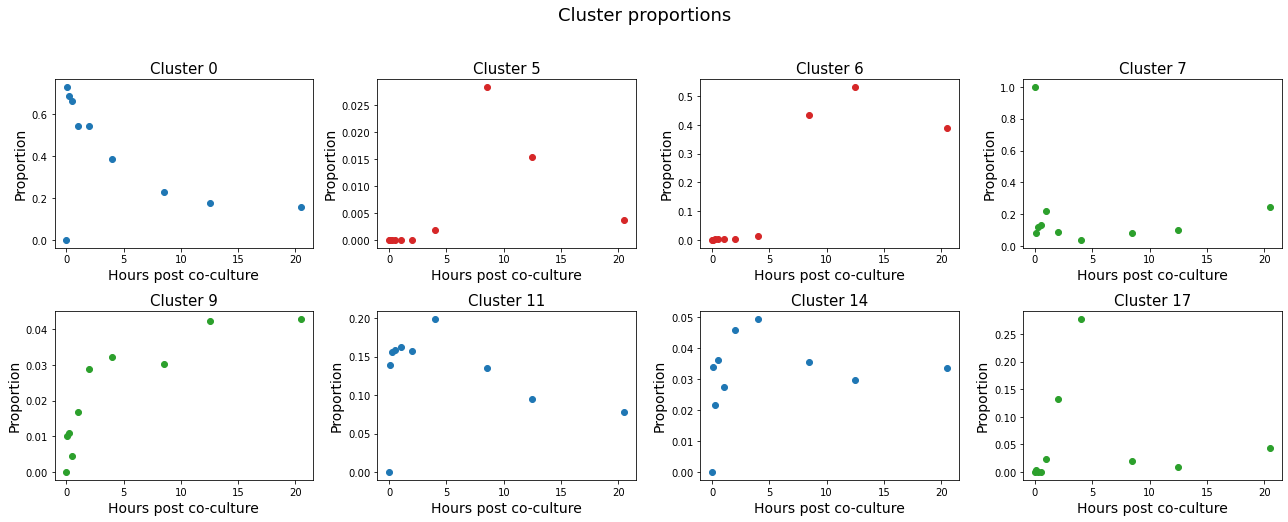

In [75]:
plt.figure(figsize=(18, 7))
for i, cluster in enumerate(clusters_unique):
    metacluster = cluster_to_metacluster[cluster]
    color = metacluster_to_color[metacluster]
    plt.subplot(2, 4, i+1)
    plt.scatter(cluster_proportions_over_time.index, 
                cluster_proportions_over_time[cluster], 
                color=color)
    plt.title(f'Cluster {cluster}', fontsize=15)
    plt.ylabel('Proportion', fontsize=14)
    plt.xlabel('Hours post co-culture', fontsize=14)
plt.suptitle(f'Cluster proportions', y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_method/cluster_proportions.eps', 
            bbox_inches='tight')

In [76]:
hours_post_coculture = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
hours_post_coculture = {i: hour for i, hour in enumerate(hours_post_coculture)}

gene_exp_df = pickle.load(open('../../data/CAR-T ratios and umap/data_df_revised_clusters.pkl', 'rb'))

# Filter to experiment
gene_exp_df = gene_exp_df[gene_exp_df.index.str.startswith('CARC')]
gene_exp_df = gene_exp_df[gene_exp_df.index.isin(df.index)]
# Update cluster number to Leiden clusters
gene_exp_df['cluster_number'] = df['cluster_number']
gene_exp_df['timestamp'] = [int(index_split[1][1]) 
                            for index_split in gene_exp_df.index.str.split('_')]
gene_exp_df['timestamp'] = gene_exp_df['timestamp'].replace(hours_post_coculture)
genes = gene_exp_df.columns[:-2]
gene_exp_df

,MIR1302-2HG,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,SAMD11,NOC2L,...,AC145212.1,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC233755.1,AC240274.1,cluster_number,timestamp
CARC_T8_AAACCTGAGAAGGCCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,12.50
CARC_T9_AAACCTGAGACAAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,7,20.50
CARC_T6_AAACCTGAGACAATAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,7,4.00
CARC_T9_AAACCTGAGCCATCGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.633307,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0,20.50
CARC_T2_AAACCTGAGGTAGCTG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.990700,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,11,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,11,20.50
CARC_T9_TTTGTCATCGACGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.445403,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,20.50
CARC_T9_TTTGTCATCGGCTTGG,-2.302585,-2.302585,-2.302585,-2.302585,-0.744831,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,20.50
CARC_T7_TTTGTCATCGTGGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,8.50


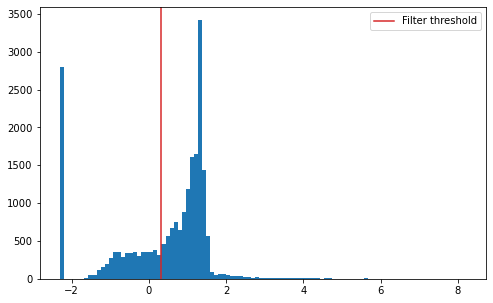

In [77]:
threshold = 0.3

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df[genes].max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [78]:
print("Percent genes removed:", (gene_exp_df[genes].max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df[genes].max() <= threshold)
genes = genes[~gene_filter]
gene_exp_df = gene_exp_df.drop(columns=gene_filter[gene_filter].index)
gene_exp_df

Percent genes removed: 34.44424508836458


,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,...,MT-ND5,MT-ND6,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,cluster_number,timestamp
CARC_T8_AAACCTGAGAAGGCCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,1.525979,0.202868,3.453078,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,12.50
CARC_T9_AAACCTGAGACAAGCC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,1.320962,-2.302585,3.312464,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,7,20.50
CARC_T6_AAACCTGAGACAATAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.117269,-2.302585,...,0.764930,-0.490678,2.670134,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,7,4.00
CARC_T9_AAACCTGAGCCATCGC,-2.302585,-2.302585,-2.302585,-0.633307,-2.302585,-2.302585,-2.302585,-2.302585,-0.039088,-2.302585,...,1.662030,-0.039088,3.094332,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0,20.50
CARC_T2_AAACCTGAGGTAGCTG,-2.302585,-2.302585,-2.302585,-0.990700,-2.302585,-2.302585,-2.302585,-2.302585,0.169968,-2.302585,...,2.040814,-0.442180,3.253281,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,11,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARC_T9_TTTGTCATCATGTAGC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.648138,-2.302585,...,1.867426,-2.302585,3.882065,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,11,20.50
CARC_T9_TTTGTCATCGACGGAA,-2.302585,-2.302585,-2.302585,-0.445403,-2.302585,-2.302585,-2.302585,-2.302585,-0.445403,-2.302585,...,2.199371,-0.093378,3.040313,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,20.50
CARC_T9_TTTGTCATCGGCTTGG,-2.302585,-0.744831,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.744831,-2.302585,...,2.248167,0.202486,3.150104,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,20.50
CARC_T7_TTTGTCATCGTGGGAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,2.077422,-2.302585,3.247368,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,8.50


In [79]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])

# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
7,P05019,P08069,IGF1,IGF1R,True,True,False,True,True,False,27,Baccin2019:1852007;Baccin2019:2877871;CA1:8408...,Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...,11287679;12067807;14604834;185;1852007;1902995...,15,42,26
8,P46531,P78504,NOTCH1,JAG1,True,True,False,False,False,False,16,Baccin2019:11006133;BioGRID:11006133;DIP:18660...,Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntA...,11006133;16713569;17537801;18495817;18660822;2...,9,14,13
9,P78504,P46531,JAG1,NOTCH1,True,True,True,True,True,False,36,ACSN:22330899;ACSN:22363130;Baccin2019:7697721...,ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;Ce...,10958687;11;11006133;15137944;16713569;1692140...,20,39,27
15,Q9GZX6,Q08334,IL22,IL10RB,True,True,False,True,True,False,12,CellTalkDB:10875937;HPRD:10875937;LRdb:1087593...,CellCall;CellTalkDB;Fantom5_LRdb;Guide2Pharma;...,10875937;12513909;15120653;17208301;18509351;2...,6,20,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8297,P34925,Q9NPG1,RYK,FZD3,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8304,Q01974,O60353,ROR2,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8305,P34925,O60353,RYK,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8322,P09486,Q9GZP0,SPARC,PDGFD,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1


In [80]:
sample_to_cluster_to_degs = dict()

for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):
    print(timestamp)
    sample_to_cluster_to_degs[timestamp] = dict()
    sample_gene_exp_df = gene_exp_df[(gene_exp_df['timestamp'] == timestamp) & 
                                     (gene_exp_df['cluster_number'].isin(clusters_unique))]
    clusters_with_more_than_1_cell = sample_gene_exp_df['cluster_number'].value_counts()\
                                        [sample_gene_exp_df['cluster_number'].value_counts() > 1].index
    sample_gene_exp_df = sample_gene_exp_df[sample_gene_exp_df['cluster_number'].isin(clusters_with_more_than_1_cell)]
    if sample_gene_exp_df.shape[0] == 0: continue
    sample_adata = sc.AnnData(sample_gene_exp_df[genes], 
                              obs=sample_gene_exp_df[['cluster_number']].astype('str'))
    sc.tl.rank_genes_groups(sample_adata, groupby='cluster_number', method='wilcoxon', key_added='wilcoxon')
    for cluster in clusters_unique:
        if cluster not in clusters_with_more_than_1_cell: 
            sample_to_cluster_to_degs[timestamp][cluster] = []
            continue
        sample_cluster_deg_df = sc.get.rank_genes_groups_df(sample_adata, group=str(cluster), key='wilcoxon')
        top_degs = sample_cluster_deg_df[(sample_cluster_deg_df['pvals_adj'] <= 0.01) & 
                                         (sample_cluster_deg_df['scores'] >= 0)]
        sample_to_cluster_to_degs[timestamp][cluster] = list(zip(top_degs['names'], top_degs['scores']))

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_99417/1841455938.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):


  0%|          | 0/10 [00:00<?, ?it/s]

12.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

20.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

4.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.25


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

2.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

8.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

1.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.08333333333333333
0.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

In [81]:
def create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, rl_pairs, clusters_of_interest, 
                                             sample_to_cluster_to_degs):
    sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
    sample_cluster_avg_gene_exp = sample_gene_exp_df.groupby('cluster_number').mean()
    cluster_interaction_score_matrix = np.full((len(clusters_of_interest), len(clusters_of_interest)), 
                                               np.nan)
    for row, receiver_cluster in enumerate(clusters_of_interest):
        for col, sender_cluster in enumerate(clusters_of_interest):
            if (receiver_cluster in sample_cluster_avg_gene_exp.index and 
                sender_cluster in sample_cluster_avg_gene_exp.index):
                ligand_gene_expressions = sample_cluster_avg_gene_exp.loc[sender_cluster][rl_pairs['source_genesymbol']]
                receptor_gene_expressions = sample_cluster_avg_gene_exp.loc[receiver_cluster][rl_pairs['target_genesymbol']]
                # Filter down to highly co-expressed and differentially-expressed RL pairs
                sample_sender_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][sender_cluster]]
                sample_receiver_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][receiver_cluster]]
                rl_interaction_thresholded = \
                    (ligand_gene_expressions.index.isin(sample_sender_cluster_degs) & 
                     receptor_gene_expressions.index.isin(sample_receiver_cluster_degs))
                cluster_interaction_score_matrix[row][col] = rl_interaction_thresholded.sum()
    return cluster_interaction_score_matrix

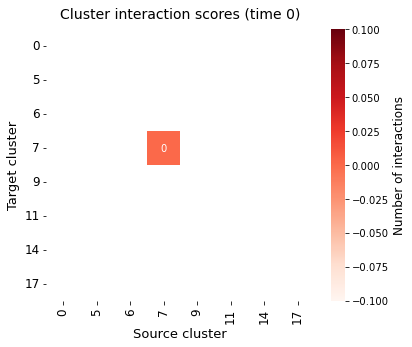

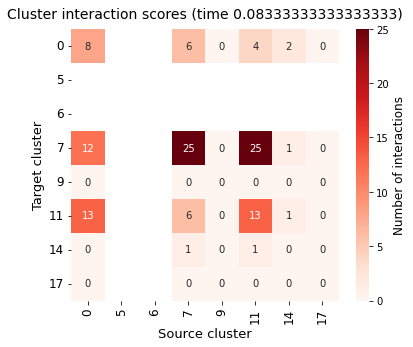

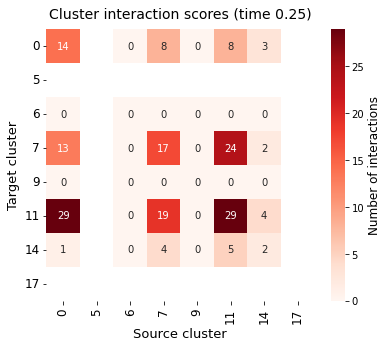

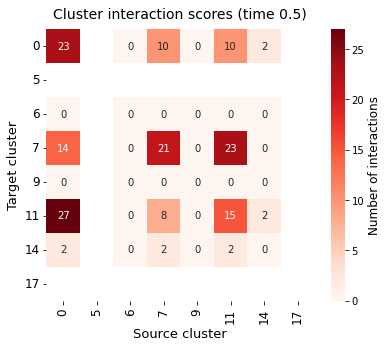

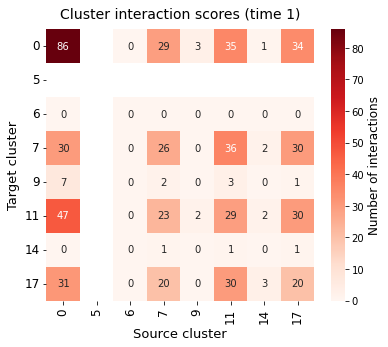

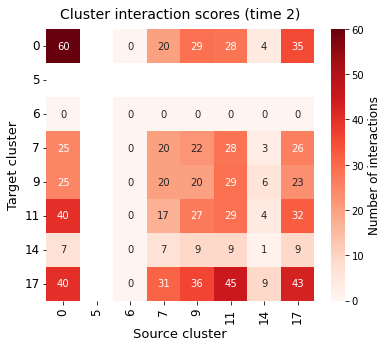

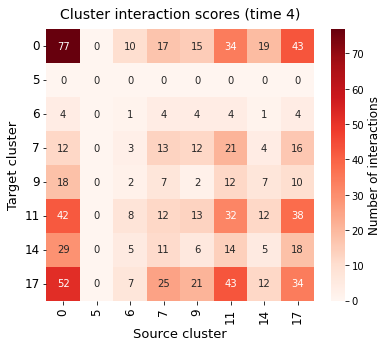

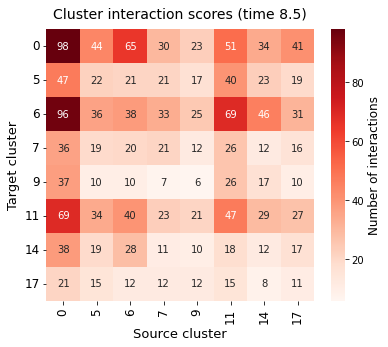

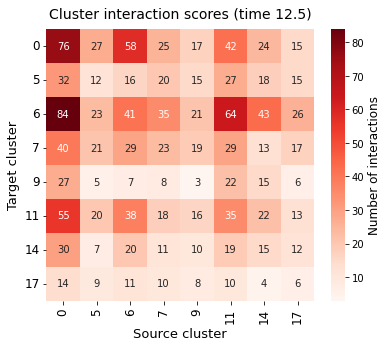

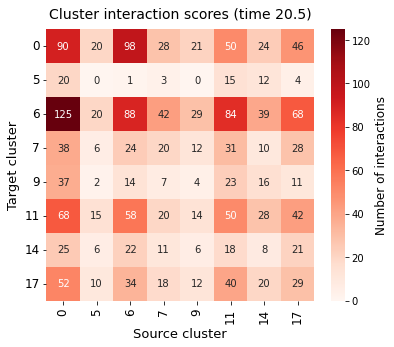

In [82]:
sample_cluster_interaction_score_matrices = {}

for timestamp in hours_post_coculture.values():
    cluster_interaction_score_matrix = create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, 
                                            rl_pairs, clusters_unique, sample_to_cluster_to_degs)
    sample_cluster_interaction_score_matrices[timestamp] = cluster_interaction_score_matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cluster_interaction_score_matrix, cmap="Reds", annot=True, fmt='.0f', 
                     cbar_kws={'label': 'Number of interactions'})
    ax.figure.axes[-1].yaxis.label.set_size(12)
    ax.set_yticklabels(clusters_unique, rotation=0, fontsize=12)
    ax.set_xticklabels(clusters_unique, rotation=90, fontsize=12)
    plt.xlabel('Source cluster', fontsize=13)
    plt.ylabel('Target cluster', fontsize=13)
    plt.title(f'Cluster interaction scores (time {timestamp})', fontsize=14, y=1.02)

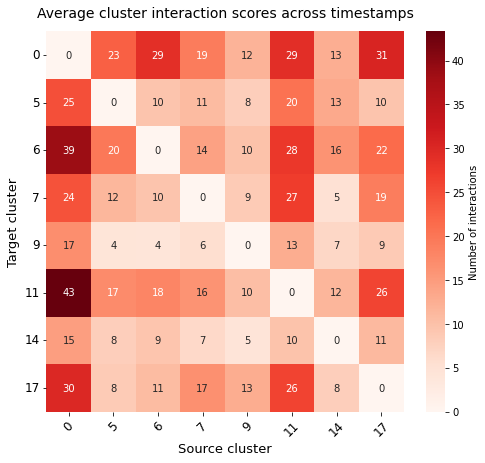

In [83]:
avg_cluster_interaction_score = np.nanmean(
    np.array(list(sample_cluster_interaction_score_matrices.values())), 
    axis=0)
np.fill_diagonal(avg_cluster_interaction_score, 0)

plt.figure(figsize=(8, 7))
ax = sns.heatmap(avg_cluster_interaction_score, cmap="Reds", 
                 annot=True, fmt='.0f', cbar_kws={'label': 'Number of interactions'})
ax.set_yticklabels(clusters_unique, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_unique, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Average cluster interaction scores across timestamps', fontsize=14, y=1.02)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_method/interaction_scores.eps', 
            bbox_inches='tight')

Text(0.5, 1.0, 'Distribution of average interaction scores')

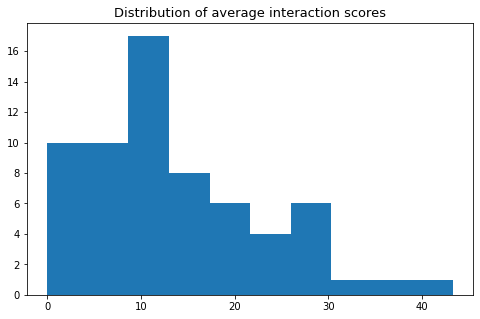

In [84]:
plt.figure(figsize=(8, 5))
plt.hist(avg_cluster_interaction_score.flatten(), bins=10)
plt.title('Distribution of average interaction scores', fontsize=13)

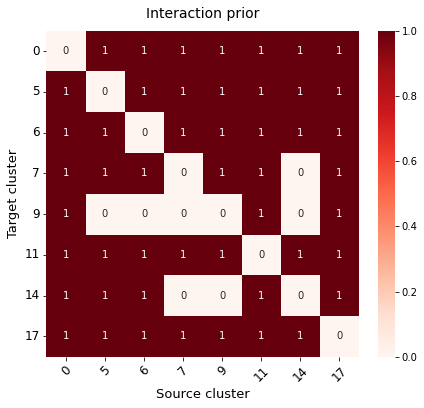

In [85]:
interaction_prior = avg_cluster_interaction_score >= 8

plt.figure(figsize=(7, 6))
ax = sns.heatmap(interaction_prior, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_unique, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_unique, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Interaction prior', fontsize=14, y=1.02)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_method/interaction_prior.eps', 
            bbox_inches='tight')

In [86]:
X = cluster_proportions_over_time.index.values.reshape(-1, 1)
X

array([[ 0.        ],
       [ 0.08333333],
       [ 0.25      ],
       [ 0.5       ],
       [ 1.        ],
       [ 2.        ],
       [ 4.        ],
       [ 8.5       ],
       [12.5       ],
       [20.5       ]])

In [87]:
Y = cluster_proportions_over_time.values
Y

array([[0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.73220339, 0.        , 0.        , 0.08135593, 0.01016949,
        0.13898305, 0.03389831, 0.00338983],
       [0.69077758, 0.        , 0.00180832, 0.11934901, 0.01084991,
        0.15551537, 0.02169982, 0.        ],
       [0.66363636, 0.        , 0.00227273, 0.13409091, 0.00454545,
        0.15909091, 0.03636364, 0.        ],
       [0.54482759, 0.        , 0.00295567, 0.22068966, 0.01674877,
        0.16256158, 0.02758621, 0.02463054],
       [0.54391218, 0.        , 0.00499002, 0.08682635, 0.02894212,
        0.15768463, 0.04590818, 0.13173653],
       [0.3868011 , 0.00183318, 0.01466544, 0.03941338, 0.03208066,
        0.19890009, 0.04949588, 0.27681027],
       [0.23149819, 0.0284296 , 0.43546931, 0.08348375, 0.03023466,
        0.1349278 , 0.03564982, 0.02030686],
       [0.17433752, 0.0153417 , 0.53277545, 0.10134821, 0.0423059 ,
        0.09483961, 0.029753

In [88]:
t_subset_num = 12
timepoints = torch.tensor(X)[:t_subset_num]
proportions = torch.tensor(Y)[:t_subset_num]
prior_matrix = torch.tensor(interaction_prior)
n_timepoints, n_cell_types = proportions.shape

# z score the proportions
proportions_mean = proportions.mean(dim=0)
proportions_std = proportions.std(dim=0)
# proportions = proportions - proportions_mean
proportions = (proportions - proportions_mean)/ (proportions_std)
#proportions = proportions / proportions_std


print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([10, 1])
cell_types.shape: torch.Size([10, 8])


In [89]:
def unscale(proportions, cluster_index): 
    return np.clip(proportions * 
                   proportions_std.detach().numpy()[cluster_index] + 
                   proportions_mean.detach().numpy()[cluster_index], 
                   0, None)

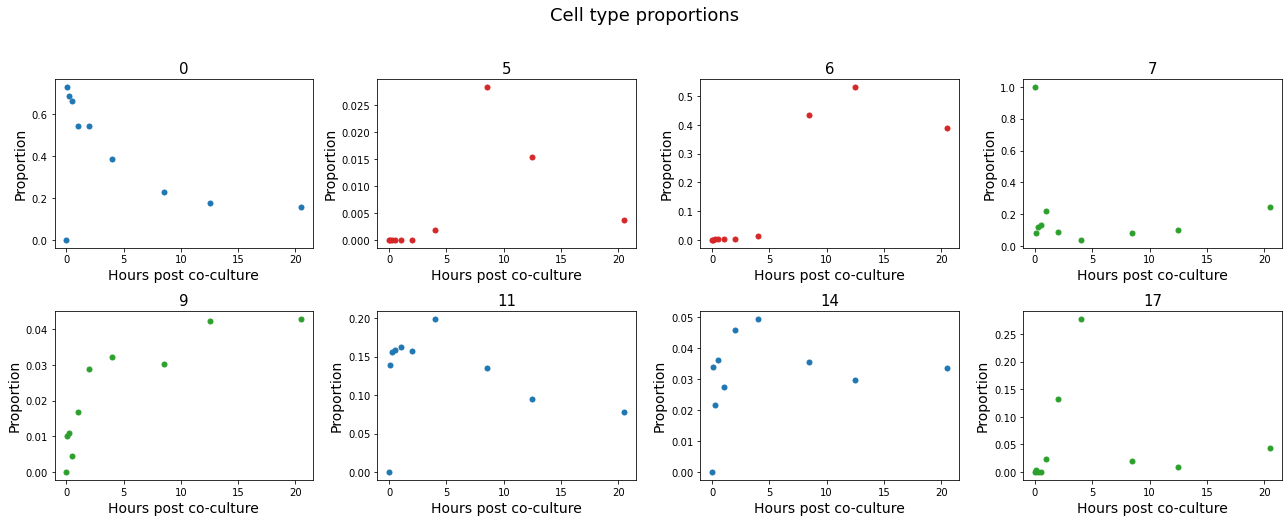

In [90]:
plt.figure(figsize=(18, 7))
for i, cluster in enumerate(clusters_unique):
    metacluster = cluster_to_metacluster[cluster]
    color = metacluster_to_color[metacluster]
    plt.subplot(2, 4, i+1)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=25)
    plt.title(f'{cluster}', fontsize=15)
    plt.ylabel('Proportion', fontsize=14)
    plt.xlabel('Hours post co-culture', fontsize=14)
plt.suptitle('Cell type proportions', fontsize=18, y=1.03)
plt.tight_layout()

In [91]:
# mean of all intervals
lengthscale_f = np.mean(np.abs(X - X.T))
lengthscale_f

6.483333333333333

In [92]:
j = interaction_prior.sum(axis=1).max()
lengthscale_W = max([X[i, 0] - X[i-j+1, 0] 
                     for i in range(j-1, X.shape[0])])
lengthscale_W

20.0

In [93]:
hyper_init_vals = {
    names.LENGTHSCALE_F: lengthscale_f,
    names.LENGTHSCALE_W: lengthscale_W,
    names.SIGMA_F: 0.5,
    names.VARIANCE_F: 1,
    names.SIGMA_W: 0.1,
    names.VARIANCE_W: 1,
    names.SIGMA_Y: 0.5,
}
print(hyper_init_vals)

{'lengthscale_f': 6.483333333333333, 'lengthscale_w': 20.0, 'sigma_f': 0.5, 'variance_f': 1, 'sigma_w': 0.1, 'variance_w': 1, 'sigma_y': 0.5}


In [94]:
model = DIISCO(lambda_matrix=prior_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

In [95]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)

In [96]:
model.fit(timepoints, 
          proportions, 
          n_iter=10000, 
          lr=0.00005,
          hypers_to_optim=[], 
          guide="MultivariateNormalFactorized")

[iteration 0001] loss: 42532.9722
[iteration 0101] loss: 21522.5082
[iteration 0201] loss: 19932.1119
[iteration 0301] loss: 19107.1302
[iteration 0401] loss: 17871.1364
[iteration 0501] loss: 17222.4663
[iteration 0601] loss: 16886.0056
[iteration 0701] loss: 16472.0778
[iteration 0801] loss: 17253.9113
[iteration 0901] loss: 16106.3469
[iteration 1001] loss: 15570.3806
[iteration 1101] loss: 15790.5485
[iteration 1201] loss: 14865.8520
[iteration 1301] loss: 14893.4945
[iteration 1401] loss: 14350.7172
[iteration 1501] loss: 14472.4871
[iteration 1601] loss: 14213.8575
[iteration 1701] loss: 14327.5181
[iteration 1801] loss: 15196.5545
[iteration 1901] loss: 14384.5992
[iteration 2001] loss: 14132.0874
[iteration 2101] loss: 13310.6339
[iteration 2201] loss: 13280.9659
[iteration 2301] loss: 13166.7920
[iteration 2401] loss: 13299.8244
[iteration 2501] loss: 12979.9365
[iteration 2601] loss: 12738.3862
[iteration 2701] loss: 12940.5787
[iteration 2801] loss: 12941.4098
[iteration 290

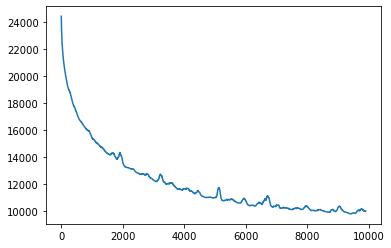

In [97]:
start = 0
loss_moving_avg = np.convolve(model.losses[start:], np.ones(100)/100, 'valid')
plt.plot(loss_moving_avg)

Text(0.5, 0.95, 'DIISCO y samples')

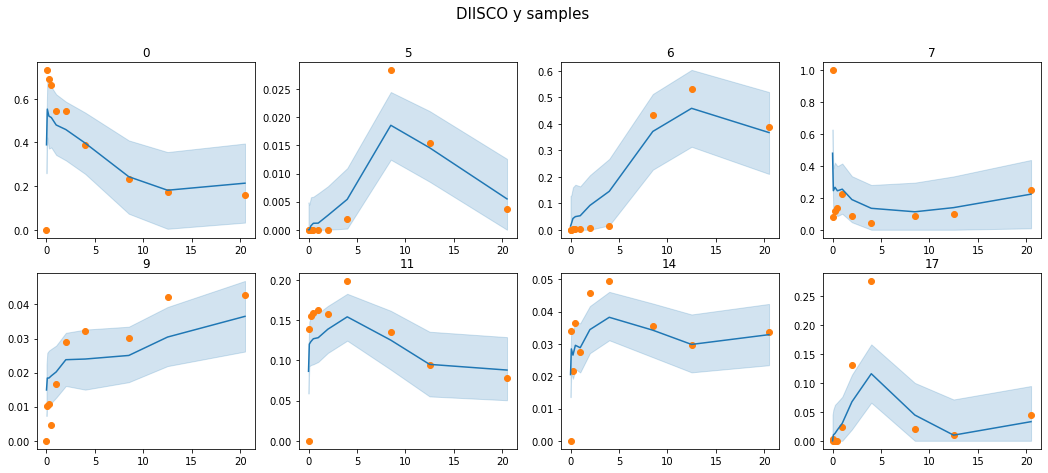

In [98]:
y = model.sample_observed_proportions(n_samples=1000).detach()

plt.figure(figsize=(18, 11))
for i, cluster in enumerate(clusters_unique):
    cell_type_samples = y[:, :, i]
    metacluster = cluster_to_metacluster[cluster]
    color = metacluster_to_color[metacluster]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    plt.subplot(3, 4, i+1)
    plt.plot(timepoints, mean, c='tab:blue')
    plt.fill_between(timepoints.squeeze(), percentile_25, percentile_75, color='tab:blue', alpha=0.2)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c='tab:orange')
    plt.title(clusters_unique[i])

plt.suptitle('DIISCO y samples', fontsize=15, y=0.95)

In [99]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
samples = model.sample(predict_timepoints, 
                       n_samples=10000, 
                       n_samples_per_latent=10,
                       include_emission_variance=True)

100%|████████████████████████████████████| 10000/10000 [01:05<00:00, 153.69it/s]


In [100]:
W_samples_predict = samples['W']
f_samples_predict = samples['F']
y_samples_predict = samples['Y']

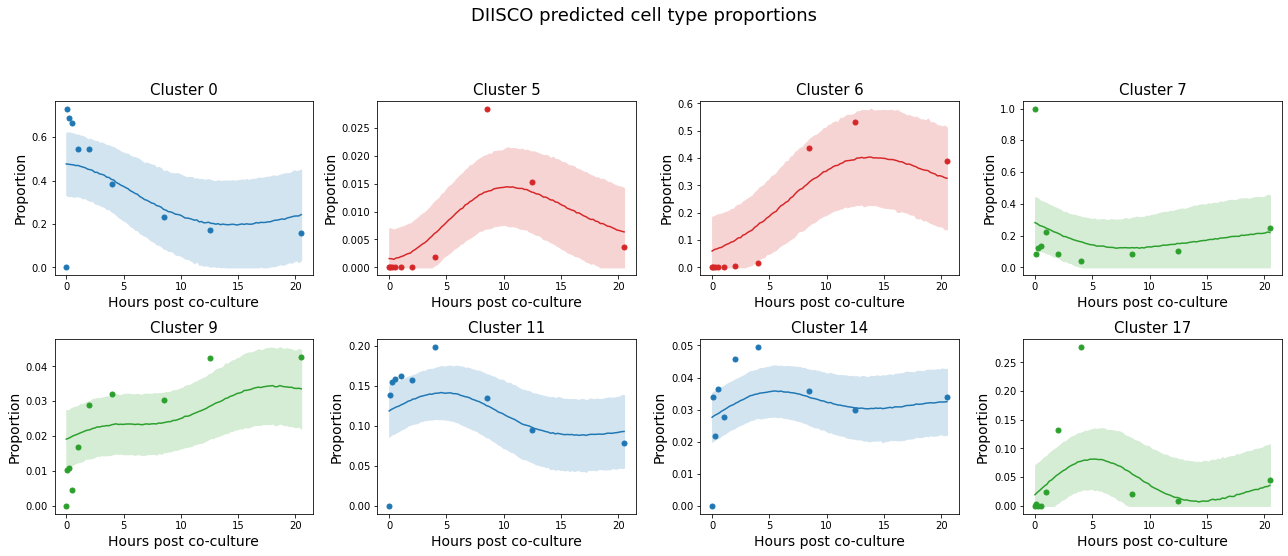

In [101]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors

plt.figure(figsize=(18, 10))
for i, y_i in enumerate(Y.T):
    metacluster = cluster_to_metacluster[clusters_unique[i]]
    color = metacluster_to_color[metacluster]
    cell_type_samples = y_samples_predict[:, :, i]
    mean = unscale(cell_type_samples.mean(axis=0), i)
    x = predict_timepoints.squeeze().numpy()
    percentile_75 = unscale(np.percentile(cell_type_samples, 84, axis=0), i)
    percentile_25 = unscale(np.percentile(cell_type_samples, 16, axis=0), i)
    color_with_alpha = list(colors.to_rgb(color)) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    plt.subplot(3, 4, i+1)
    line = plt.plot(x, mean, c=color)
    plt.fill_between(x, percentile_25, percentile_75, color=color_without_alpha)
    plt.scatter(timepoints, unscale(proportions[:, i], i), c=color, s=25)
    plt.title(f'Cluster {clusters_unique[i]}', fontsize=15)
    plt.xlabel('Hours post co-culture', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
#     plt.ylim([-0.05, 1.05])
plt.suptitle('DIISCO predicted cell type proportions', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_method/predicted_proportions.eps', 
            bbox_inches='tight')

Text(0.5, 1.05, 'DIISCO predicted interactions ($\\hat{W}_{avg})$')

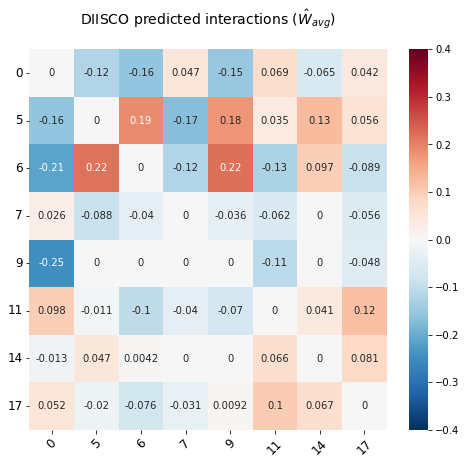

In [102]:
plt.figure(figsize=(8, 7))
W_avg_over_time = W_samples_predict.mean(axis=(0, 1)).detach().numpy()
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmax=0.4, vmin=-0.4, center=0)
ax.set_yticklabels(clusters_unique, fontsize=12)
ax.set_xticklabels(clusters_unique, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('DIISCO predicted interactions ($\hat{W}_{avg})$', fontsize=14, y=1.05)

In [103]:
metacluster_to_clusters

{'MEC1 cells': array([ 0, 11, 14]),
 'Activated T cells': array([17,  7,  9]),
 'Exhausted T cells': array([6, 5])}

In [104]:
clusters_rearranged = np.concatenate(list(metacluster_to_clusters.values()))
clusters_rearranged_indices = [clusters_unique.index(cluster) 
                               for cluster in clusters_rearranged]
print(clusters_rearranged)
print(clusters_rearranged_indices)

[ 0 11 14 17  7  9  6  5]
[0, 5, 6, 7, 3, 4, 2, 1]


In [105]:
W_avg_over_time_rearranged = W_avg_over_time[:, clusters_rearranged_indices]
W_avg_over_time_rearranged = W_avg_over_time_rearranged[clusters_rearranged_indices, :]
W_avg_over_time_rearranged.shape

(8, 8)

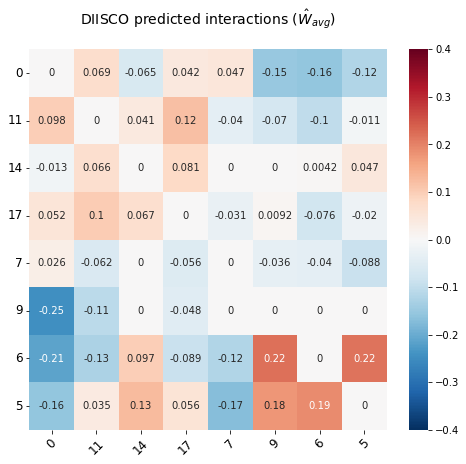

In [106]:
plt.figure(figsize=(8, 7))
ax = sns.heatmap(W_avg_over_time_rearranged, cmap="RdBu_r", annot=True, 
                 vmax=0.4, vmin=-0.4, center=0)
ax.set_yticklabels(clusters_rearranged, fontsize=12)
ax.set_xticklabels(clusters_rearranged, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('DIISCO predicted interactions ($\hat{W}_{avg})$', fontsize=14, y=1.05)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_method/W_avg.eps', 
            bbox_inches='tight')

In [107]:
W = W_samples_predict.mean(axis=0)
W.shape

torch.Size([100, 8, 8])

In [108]:
mean_abs_W_threshold = 0.18
max_abs_W_threshold = 0.18

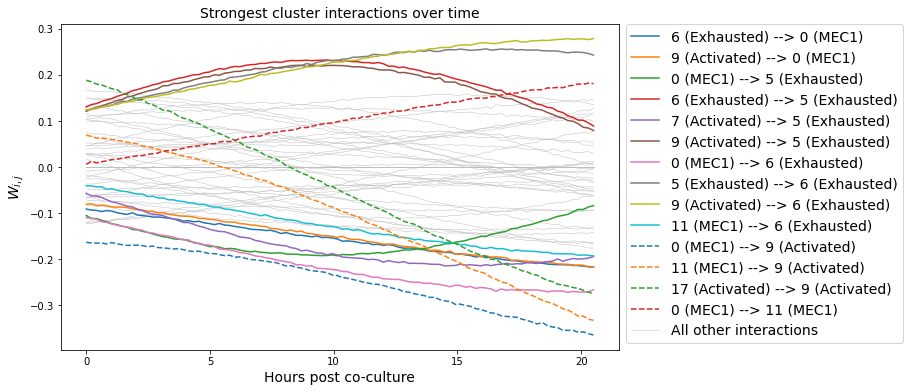

In [109]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', ":"]
lines = 0
for i, cluster_i in enumerate(clusters_unique):
    for j, cluster_j in enumerate(clusters_unique):
        # a sustained strong interaction over the entire time period
        sustained = (np.abs(W[:, i, j]) > mean_abs_W_threshold).all()
        # a transient strong interaction during the time period
        transient = (np.abs(W[:, i, j]) > max_abs_W_threshold).any()
        show_line = (sustained or transient)
        if show_line and i!= j:
            plt.plot(predict_timepoints.squeeze(),
                     W[:, i, j],
                     linestyle=linestyles[lines//10],
                     label='%s (%s) --> %s (%s)' % (cluster_j, cluster_to_metacluster[cluster_j].split(' ')[0],
                                                   cluster_i, cluster_to_metacluster[cluster_i].split(' ')[0]))
            lines += 1
            
once = False
color = 'tab:gray'
color_with_alpha = list(colors2.to_rgb(color)) + [0.5]
color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.5)
for i, cluster_i in enumerate(clusters_unique):
    for j, cluster_j in enumerate(clusters_unique):
        # a sustained strong interaction over the entire time period
        sustained = (np.abs(W[:, i, j]) > mean_abs_W_threshold).all()
        # a transient strong interaction during the time period
        transient = (np.abs(W[:, i, j]) > max_abs_W_threshold).any()
        show_line = (sustained or transient)
        if not show_line and i != j:
            plt.plot(predict_timepoints.squeeze(), 
                     W[:, i, j],
                     color=color_without_alpha[0],
                     linewidth=0.5, zorder=-100,
                     label='All other interactions' if not once else '')
            once = True

plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=14)
plt.title('Strongest cluster interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Hours post co-culture', fontsize=14)
plt.savefig(f'../../figures/CAR-T/revisions/robustness_cluster_method/W_over_time.eps', 
            bbox_inches='tight')